In [1]:
api_key = '###############################################################'
secret = '###############################################################'

In [2]:
import pandas as pd
import random
from datetime import datetime
from prophet import Prophet
from binance.futures import Futures as Client
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from fitter import Fitter, get_common_distributions, get_distributions

In [3]:
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [493]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [132]:
import ta

In [5]:
futures_client = Client()

In [6]:
data_1m = futures_client.mark_price_klines("BTCUSDT", "1m", **{"limit": 1000})
data_1h = futures_client.mark_price_klines("BTCUSDT", "1h", **{"limit": 1000})
data_1d = futures_client.mark_price_klines("BTCUSDT", "1d", **{"limit": 1000})
data_1w = futures_client.mark_price_klines("BTCUSDT", "1w", **{"limit": 1000})
data_1MM = futures_client.mark_price_klines("BTCUSDT", "1M", **{"limit": 100})

In [15]:
collumns = [
'Open time',
'Open',
'High',
'Low',
'Close',
'Ignore',
'Close time',
'Ignore',
'Number of bisic data',
'Ignore',
'Ignore',
'Ignore'
]

In [91]:
def to_df(data_as_array):
    df=pd.DataFrame(data_as_array, columns = collumns)
    df['Open time'] = df.apply(lambda x: datetime.fromtimestamp(int(x['Open time'])/1000) , axis=1)
    df['Close time'] = df.apply(lambda x: datetime.fromtimestamp(int(x['Close time'])/1000) , axis=1)
    df.drop(columns = ['Ignore','Number of bisic data','Close time'], inplace = True)
    df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype('float32', copy=False)
    series = df[['Open time','Open']]
    series.columns = ['ds', 'y']
    return df, series

In [92]:
df, ser = to_df(data_1h)

In [11]:
def plot_df(df):
    fig = go.Figure(data=[go.Candlestick(x=df['Open time'],
                                      open=df['Open'], 
                                      high=df['High'],
                                       low=df['Low'],
                                     close=df['Close'])
                         ], secondary_y=False)
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig

In [12]:
def plot_df_ds(df):
    fig = go.Figure(data=[go.Candlestick(x=df['ds'],
                                      open=df['Open'], 
                                      high=df['High'],
                                       low=df['Low'],
                                     close=df['Close'])
                         ])
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig

In [13]:
def build_forecast(ser, horison, periods, freq):
    '''
    freq
    
    '''
    m = Prophet(changepoint_prior_scale=0.013)
    m.fit(ser[-horison:])
    future = m.make_future_dataframe(periods=periods, freq=freq)
    forecast = m.predict(future)
    return forecast

# Forecast 1H

In [150]:
default_forecast = build_forecast(ser, 999, 1, 'H')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
fig1 = plot_df(df)
fig1.add_trace(go.Scatter(x=default_forecast['ds'], y=default_forecast['yhat_lower'],
                    mode='lines',
                    name='yhat_lower'))

fig1.add_trace(go.Scatter(x=default_forecast['ds'], y=default_forecast['yhat_upper'],
                    mode='lines',
                    name='yhat_upper'))
fig1.add_trace(go.Scatter(x=default_forecast['ds'], y=default_forecast['trend'],
                    mode='lines',
                    name='trend'))
fig1.show()

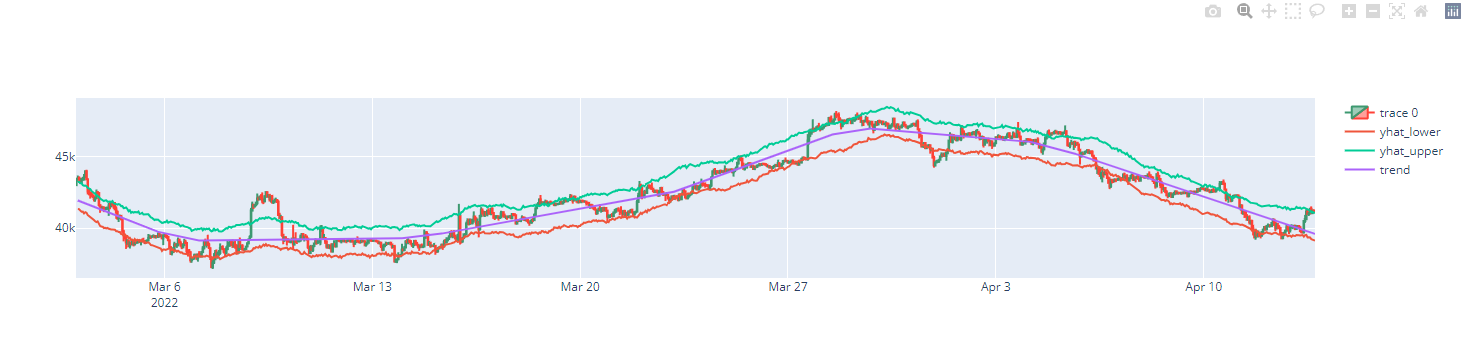

## simple cross validation of changepoint_prior_scale

In [139]:
cutoffs = pd.to_datetime([
'2022-04-12 17:00:00',
'2022-04-12 18:00:00',
'2022-04-12 19:00:00',
'2022-04-12 20:00:00',
'2022-04-12 21:00:00',
'2022-04-12 22:00:00',
'2022-04-12 23:00:00',
'2022-04-13 00:00:00',
'2022-04-13 01:00:00',
'2022-04-13 02:00:00',
'2022-04-13 03:00:00',
'2022-04-13 04:00:00',
'2022-04-13 05:00:00',
'2022-04-13 06:00:00',
'2022-04-13 07:00:00',
'2022-04-13 08:00:00',
'2022-04-13 09:00:00',
'2022-04-13 10:00:00',
'2022-04-13 11:00:00',
'2022-04-13 12:00:00',
'2022-04-13 13:00:00',
'2022-04-13 14:00:00',
'2022-04-13 15:00:00',
'2022-04-13 16:00:00'])

In [145]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.013, 0.018]
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(ser)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='1 hour', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000189A782D520>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000189A48606D0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000189A7985580>


,changepoint_prior_scale,rmse
0,0.010,662.912452
1,0.013,661.225412
2,0.018,661.950862


In [162]:
m = Prophet(changepoint_prior_scale=0.013)
m.fit(ser)
future = m.make_future_dataframe(periods=7, freq='H', include_history = True)
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [157]:
from prophet.plot import add_changepoints_to_plot

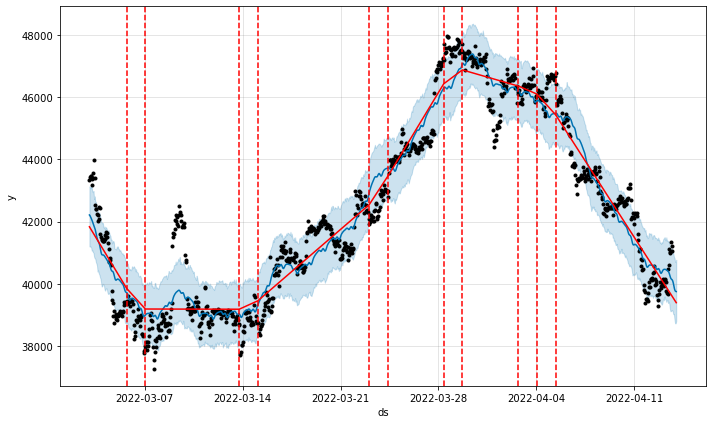

In [161]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

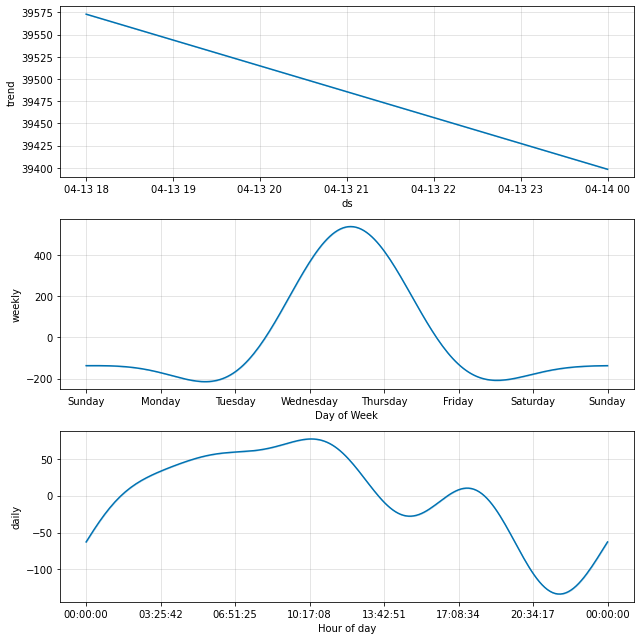

In [159]:
fig = m.plot_components(forecast)

# Forecast 1m

In [10]:
dfm, ser_m = to_df(data_1m)

In [186]:
default_forecast = build_forecast(ser_m, 999, 1, '15 min')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
dfm1=dfm[]

## channeling with default parameters

In [13]:
dfm, ser_m = to_df(data_1m)

In [11]:
def build_forecast_defoult(ser, freq):
    '''
    freq like '1 min' or D,M
    
    '''
    m = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)
    m.fit(ser)
    future = m.make_future_dataframe(periods=1,freq=freq, include_history=False)
    forecast = m.predict(future)
    return forecast

In [203]:
def channel_calculation(full_df, start, lag, period, freq):
    '''
    df - data as dataframe[['ds', 'y']]
    freq - frequence of df, like '1 min' or D,M
    start - starting point for analysis from begining of dataframe
    lag - amount of raws taken into account during forecasting, should be shorter than start!
    period - horisont of forecasting
    '''
    result = pd.DataFrame(columns = ['ds', 'trend', 'yhat_lower', 'yhat_upper'])
    for i in range(start,len(full_df), period):
        df = full_df[i-lag:i]
        forecast = build_forecast_defoult(df, freq)
        #print(forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper']])
        #result.append(forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper']], ignore_index=True)
        result = pd.concat([result, forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper']]], ignore_index=True)
    #print(result)
    return full_df.merge(result,how='left',on='ds').ffill(axis = 0)

In [17]:
result_df = channel_calculation(ser_m, 300, 300, 1,'1 min')
# may be I need to estimate average y instead of just 'Open'

In [18]:
result_df.tail()

,ds,y,trend,yhat_lower,yhat_upper
995,2022-04-14 04:07:00,41234.886719,39019.216624,41210.331401,41260.059337
996,2022-04-14 04:08:00,41230.398438,38634.392523,41202.397346,41252.469604
997,2022-04-14 04:09:00,41261.699219,38269.252274,41199.729690,41247.273305
998,2022-04-14 04:10:00,41259.500000,39275.323660,41208.136045,41255.761289
999,2022-04-14 04:11:00,41281.199219,39712.311116,41215.057233,41261.803832


In [19]:
result_df.to_csv('result_df_m.csv', index = False)

This plot looks like we can make a strategy of trading within upper-lowrer interval.
Lets try to buy on lower then sold on upper.

In [97]:
def simple_chanel_strategy(df,forecast,freq):
    '''
    df- first output of "to_df" function, this is market history data
    forecast -  output of "channel_calculation" function
    freq-friquency of rows in df and forecast like '1 min' or D,M
    
    '''
    balance = 0
    #BTC_balance = []
    BTC_balance = pd.DataFrame(columns = ['ds', 'balanse'])
    buy_price = 0
    sell_price = 0
    list_of_trades = []
    df.columns = ['ds', 'Open','High', 'Low', 'Close']
    df = df.merge(forecast[['ds','trend', 'yhat_lower', 'yhat_upper']],how='left',on='ds')
    df.dropna(inplace = True)
    for index, row in df.iterrows():
        #print(row)
        if balance == 0 and (row['Close'] < row['yhat_lower'] or row['Open']< row['yhat_lower']  or row['High']< row['yhat_lower']  or row[ 'Low']< row['yhat_lower']):
            balance = 1
            buy_price = row['Close']
        if balance == 1 and (row['Close'] > row['yhat_upper'] or row['Open']> row['yhat_upper']  or row['High']> row['yhat_upper']  or row[ 'Low']> row['yhat_upper']):
            balance = 0
            sell_price = row['Close']
            list_of_trades.append(sell_price-buy_price)
            #BTC_balance.append(sum(list_of_trades))
            BTC_balance = BTC_balance.append({'ds': row['ds'] , 'balanse': sum(list_of_trades)}, ignore_index=True)
            #result = pd.concat([result, forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper']]], ignore_index=True)
            
    return df.merge(BTC_balance,how='left',on='ds').ffill(axis = 0)

In [98]:
BTC_balance=simple_chanel_strategy(dfm, result_df, '1 min')

In [141]:
BTC_balance['rolled_trend'] = BTC_balance['Open'].rolling(30, min_periods=5, center=False).mean()
BTC_balance['rolled_trend_2'] = BTC_balance['Open'].rolling(5, min_periods=5, center=False).mean()
BTC_balance['diff_trend'] = BTC_balance['rolled_trend_2'] -BTC_balance['rolled_trend']

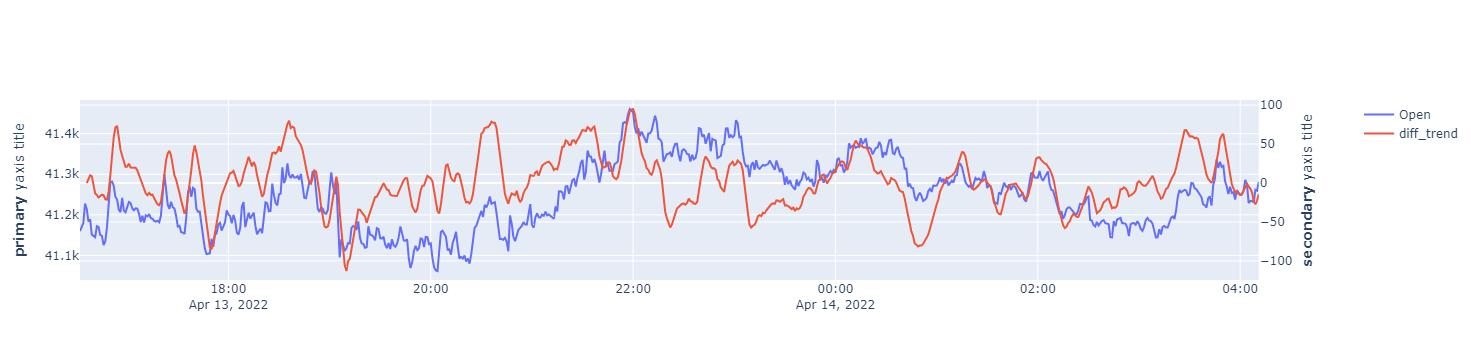

In [143]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['Open'],
                    mode='lines',
                    name='Open'),
                          secondary_y=False)

fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['diff_trend'],
                    mode='lines',
                    name='diff_trend'),
                          secondary_y=True)

#fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['rolled_trend_2'],
#                    mode='lines',
#                    name='rolled_trend_2'),
#                          secondary_y=True)
#
#fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['rolled_trend'],
#                   mode='lines',
#                   name='rolled_trend'),
#                         secondary_y=True)

fig1.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig1.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
fig1.show()

## Channeling with MA's intersection

Lets try more complex srtategy with MAs diff 

In [164]:
def MA_chanel_strategy(df,forecast,freq, ma_high, ma_low):
    '''
    df- first output of "to_df" function, this is market history data
    forecast -  output of "channel_calculation" function
    freq-friquency of rows in df and forecast like '1 min' or D,M
    ma_high, ma_low - windows for rolling(window).mean() function 
    '''
    balance = 0
    #BTC_balance = []
    BTC_balance = pd.DataFrame(columns = ['ds', 'balanse'])
    buy_price = 0
    sell_price = 0
    list_of_trades = []
    df.columns = ['ds', 'Open','High', 'Low', 'Close']
    df = df.merge(forecast[['ds','trend', 'yhat_lower', 'yhat_upper']],how='left',on='ds')
    df['rolled_open_high'] = df['Open'].rolling(ma_high, min_periods=5, center=False).mean()
    df['rolled_open_low'] = df['Open'].rolling(ma_low, min_periods=1, center=False).mean()
    df['diff_MAs'] = df['rolled_open_low'] -df['rolled_open_high']
    
    df.dropna(inplace = True)
    for index, row in df.iterrows():
        #print(row)
        if balance == 0 and (row['Close'] < row['yhat_lower'] or row['Open']< row['yhat_lower']  or row['High']< row['yhat_lower']  or row[ 'Low']< row['yhat_lower']) and row['diff_MAs'] > 0 :
            balance = 1
            buy_price = row['Close']
        if balance == 1 and (row['Close'] > row['yhat_upper'] or row['Open']> row['yhat_upper']  or row['High']> row['yhat_upper']  or row[ 'Low']> row['yhat_upper']):
            balance = 0
            sell_price = row['Close']
            list_of_trades.append(sell_price-buy_price)
            #BTC_balance.append(sum(list_of_trades))
            BTC_balance = BTC_balance.append({'ds': row['ds'] , 'balanse': sum(list_of_trades)}, ignore_index=True)
            #result = pd.concat([result, forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper']]], ignore_index=True)
            
    return df.merge(BTC_balance,how='left',on='ds').ffill(axis = 0)

In [167]:
BTC_balance=MA_chanel_strategy(dfm, result_df, '1 min', 60, 1)
BTC_balance.tail(3)

,ds,Open,High,Low,Close,trend,yhat_lower,yhat_upper,rolled_open_high,rolled_open_low,diff_MAs,balanse
697,2022-04-14 04:09:00,41261.699219,41287.199219,41250.566406,41254.554688,38269.252274,41199.729690,41247.273305,41242.316862,41261.699219,19.382357,16.597656
698,2022-04-14 04:10:00,41259.500000,41285.000000,41256.000000,41279.285156,39275.323660,41208.136045,41255.761289,41244.239518,41259.500000,15.260482,16.597656
699,2022-04-14 04:11:00,41281.199219,41285.000000,41278.101562,41284.300781,39712.311116,41215.057233,41261.803832,41246.515495,41281.199219,34.683724,16.597656


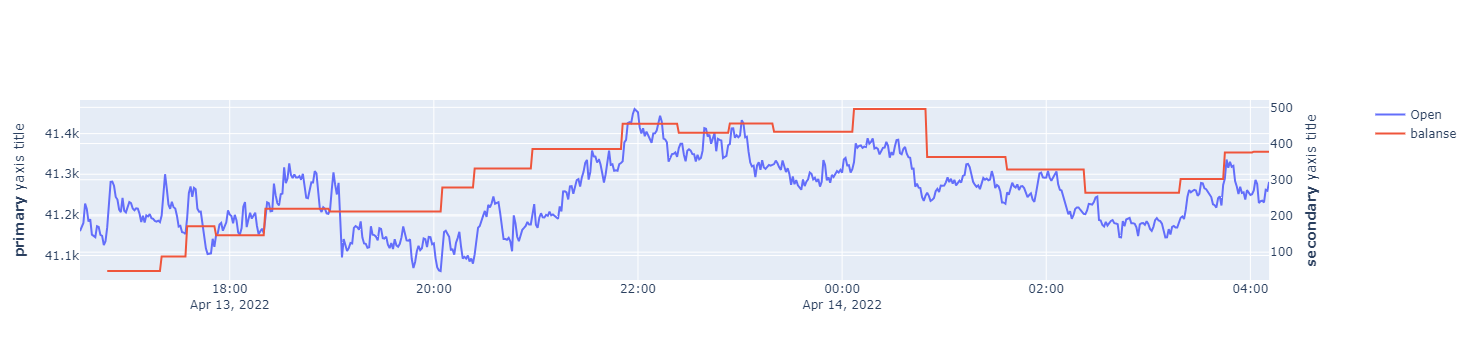

In [157]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['Open'],
                    mode='lines',
                    name='Open'),
                          secondary_y=False)

fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['balanse'],
                    mode='lines',
                    name='balanse'),
                          secondary_y=True)
fig1.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig1.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
fig1.show()

Lets try to do crossvalidation to optimise MA's parameters

In [182]:
import itertools
import numpy as np
import pandas as pd

param_grid = { 
    'ma_high': [60, 50, 40, 30, 20, 15],
    'ma_low': [1,2,3,4,5,7,10,15]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
b=[]
m_max = []
m_min =[]

# Use cross validation to evaluate all parameters
for params in all_params:
    balance=MA_chanel_strategy(dfm, result_df, '1 min', params['ma_high'], params['ma_low'])
    b.append(balance['balanse'][-1:].values[0])
    m_min.append(balance['balanse'].min())
    m_max.append(balance['balanse'].max())
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['b'] = b
tuning_results['m_max'] = m_max
tuning_results['m_min'] = m_min

In [184]:
tuning_results.groupby(['ma_high']).mean()

,ma_low,b,m_max,m_min
ma_high,,,,
15,5.875,319.856585,408.491071,21.726562
20,5.875,353.491211,453.946289,47.917969
30,5.875,326.389160,442.481934,47.917969
40,5.875,268.008301,398.433105,47.917969
50,5.875,306.072754,436.742188,47.917969
60,5.875,281.938477,401.618164,34.552734


In [186]:
tuning_results.groupby(['ma_high']).max()

,ma_low,b,m_max,m_min
ma_high,,,,
15,15,439.128906,513.140625,47.917969
20,15,494.316406,568.328125,47.917969
30,15,398.187500,515.972656,47.917969
40,15,391.171875,506.093750,47.917969
50,15,374.898438,501.917969,47.917969
60,15,374.898438,501.917969,47.917969


In [187]:
tuning_results.groupby(['ma_low']).max()

,ma_high,b,m_max,m_min
ma_low,,,,
1,60,291.074219,408.859375,47.917969
2,60,365.355469,492.375000,47.917969
3,60,365.355469,492.375000,47.917969
4,60,381.632812,495.417969,47.917969
5,60,494.316406,568.328125,47.917969
7,60,494.316406,568.328125,47.917969
10,60,421.406250,515.972656,47.917969
15,60,426.191406,526.437500,47.917969


In [188]:
tuning_results.groupby(['ma_low']).mean()

,ma_high,b,m_max,m_min
ma_low,,,,
1,35.833333,143.302083,292.935547,24.396484
2,35.833333,273.508464,391.136068,47.917969
3,35.833333,279.417318,394.116536,41.276042
4,35.833333,315.214844,429.914062,41.276042
5,35.833333,383.410156,484.851562,41.276042
7,35.833333,384.863281,483.085286,45.453125
10,35.833333,355.102865,460.774089,45.453125
15,35.833333,343.456250,460.866406,47.917969


ma_low : 5-7 , ma_high : 17-25

In [189]:
param_grid = { 
    'ma_high': [17,18,19,20,21],
    'ma_low': [5,6,7]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
b=[]
m_max = []
m_min =[]

# Use cross validation to evaluate all parameters
for params in all_params:
    balance=MA_chanel_strategy(dfm, result_df, '1 min', params['ma_high'], params['ma_low'])
    b.append(balance['balanse'][-1:].values[0])
    m_min.append(balance['balanse'].min())
    m_max.append(balance['balanse'].max())
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['b'] = b
tuning_results['m_max'] = m_max
tuning_results['m_min'] = m_min

In [196]:
tuning_results.sort_values(by = ['b'], axis=0, ascending=True).tail()

,ma_high,ma_low,b,m_max,m_min
10,20,6,494.316406,568.328125,47.917969
11,20,7,494.316406,568.328125,47.917969
12,21,5,494.316406,568.328125,47.917969
13,21,6,494.316406,568.328125,47.917969
14,21,7,494.316406,568.328125,47.917969


OK, we have long-strategy based on channel and estimator of carrent trend by intersection of MA_20 and MA_6 

In [197]:
BTC_balance=MA_chanel_strategy(dfm, result_df, '1 min', 20, 6)
BTC_balance.tail(3)

,ds,Open,High,Low,Close,trend,yhat_lower,yhat_upper,rolled_open_high,rolled_open_low,diff_MAs,balanse
697,2022-04-14 04:09:00,41261.699219,41287.199219,41250.566406,41254.554688,38269.252274,41199.729690,41247.273305,41258.323438,41244.333333,-13.990104,494.316406
698,2022-04-14 04:10:00,41259.500000,41285.000000,41256.000000,41279.285156,39275.323660,41208.136045,41255.761289,41255.258203,41241.561198,-13.697005,494.316406
699,2022-04-14 04:11:00,41281.199219,41285.000000,41278.101562,41284.300781,39712.311116,41215.057233,41261.803832,41255.152734,41250.246745,-4.905990,494.316406


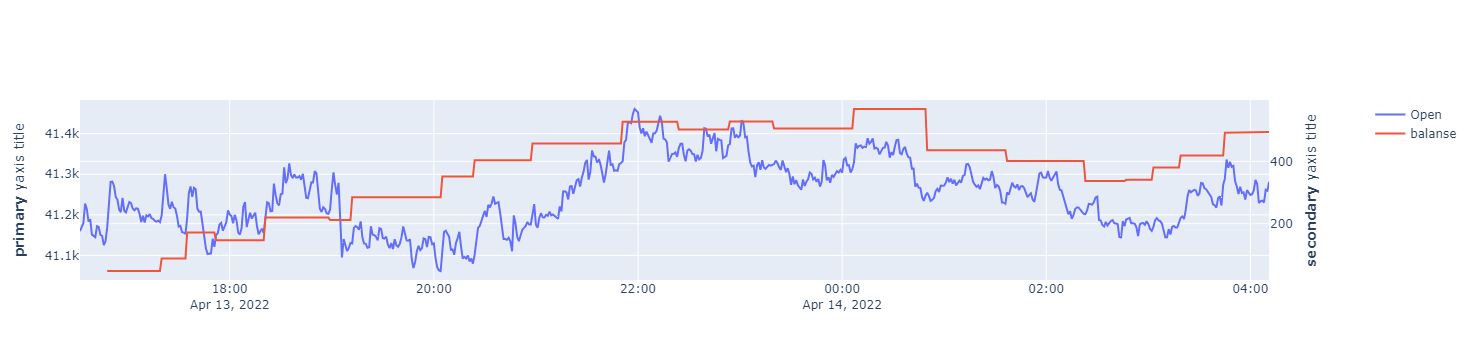

In [198]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['Open'],
                    mode='lines',
                    name='Open'),
                          secondary_y=False)

fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['balanse'],
                    mode='lines',
                    name='balanse'),
                          secondary_y=True)
fig1.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig1.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
fig1.show()

Try new data

In [199]:
data_1m = futures_client.mark_price_klines("BTCUSDT", "1m", **{"limit": 1400})

In [246]:
dfm, ser_m = to_df(data_1m)

In [204]:
result_df = channel_calculation(ser_m, 300, 300, 1,'1 min')

In [206]:
BTC_balance=MA_chanel_strategy(dfm, result_df, '1 min', 20, 6)
BTC_balance.tail(3)

,ds,Open,High,Low,Close,trend,yhat_lower,yhat_upper,rolled_open_high,rolled_open_low,diff_MAs,balanse
1097,2022-04-14 21:52:00,39935.898438,39953.199219,39935.898438,39952.898438,38664.110233,39880.437925,39939.916290,39904.015430,39925.019531,21.004102,-794.582031
1098,2022-04-14 21:53:00,39952.898438,39957.000000,39949.851562,39949.960938,40266.683722,39890.848086,39947.787039,39906.679102,39928.186198,21.507096,-794.582031
1099,2022-04-14 21:54:00,39949.960938,39951.621094,39949.957031,39951.500000,41806.667115,39896.843656,39958.901348,39909.396680,39933.743490,24.346810,-794.582031


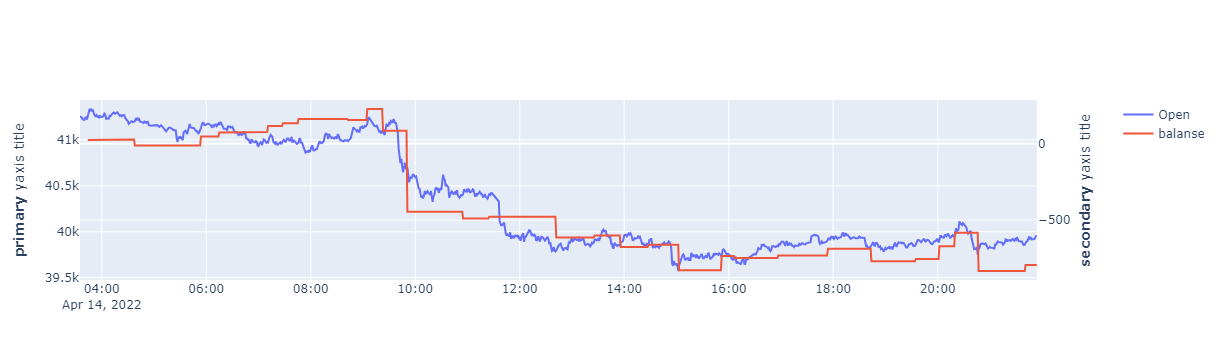

In [207]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['Open'],
                    mode='lines',
                    name='Open'),
                          secondary_y=False)

fig1.add_trace(go.Scatter(x=BTC_balance['ds'], y=BTC_balance['balanse'],
                    mode='lines',
                    name='balanse'),
                          secondary_y=True)
fig1.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig1.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
fig1.show()

In [208]:
param_grid = { 
    'ma_high': [60, 50, 40, 30, 20, 15],
    'ma_low': [1,2,3,4,5,7,10,15]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
b=[]
m_max = []
m_min =[]

# Use cross validation to evaluate all parameters
for params in all_params:
    balance=MA_chanel_strategy(dfm, result_df, '1 min', params['ma_high'], params['ma_low'])
    b.append(balance['balanse'][-1:].values[0])
    m_min.append(balance['balanse'].min())
    m_max.append(balance['balanse'].max())
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['b'] = b
tuning_results['m_max'] = m_max
tuning_results['m_min'] = m_min

In [ ]:
fig1 = plot_df_ds(dfm)
fig1.add_trace(go.Scatter(x=result_df['ds'], y=result_df['yhat_lower'],
                    mode='lines',
                    name='yhat_lower'))

fig1.add_trace(go.Scatter(x=result_df['ds'], y=result_df['yhat_upper'],
                    mode='lines',
                    name='yhat_upper'))
fig1.show()

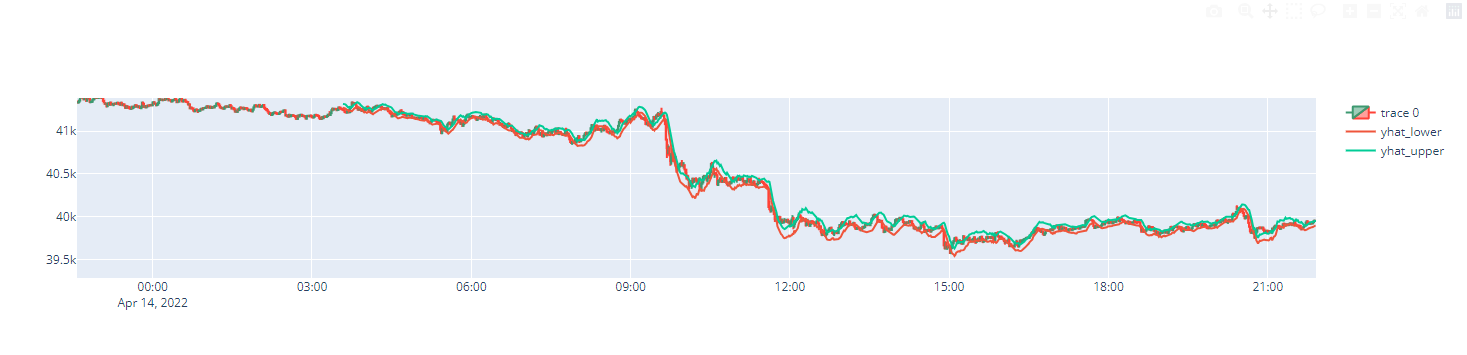

WE NEED STOP_LOSS 

it seems that we have to brake down this function ***MA_chanel_strategy*** on several

JUST REALIZE we need check distributions of value ***yhat_upper - open***\
and list of hyperparameters to adjust (lag, some channel parameter, MAs, SL, TP, friq)

In [219]:
def y_upper_more_than_candle(row):
     return (row['Close'] > row['yhat_upper'] or row['Open']> row['yhat_upper']  or row['High']> row['yhat_upper']  or row[ 'Low']> row['yhat_upper'])

In [220]:
def y_lower_less_than_candle(row):
     return (row['Close'] < row['yhat_lower'] or row['Open']< row['yhat_lower']  or row['High']< row['yhat_lower']  or row[ 'Low']< row['yhat_lower'])

In [ ]:
def open_long(row, BTC_balance, long_positions):
    

## RSI strategies

long_positions - df for all opened positions, a long position should be added when it opened\
long_trades - df for all closed long trades, a row should be added when it closed, id - id of long position \
BTC_balance - each row of this df is account balance at the moment 'ds'

In [229]:
long_positions = pd.DataFrame(columns = ['id', 'ds', 'buy_price', 'amount', 'TP_price', 'SL_price'])
long_trades = pd.DataFrame(columns = ['id', 'ds', 'buy_price', 'amount', 'sell_price', 'result'])
BTC_balance = pd.DataFrame(columns = ['ds', 'balanse', 'open_long_position'])

In [231]:
BTC_balance

,ds,balanse,open_long_position


Before continue building strategy we need learn library 'ta'

In [131]:
import ta

In [259]:
rsi = ta.momentum.RSIIndicator(dfm['Open'], 14, False)

In [262]:
adx = ta.trend.ADXIndicator(dfm['Open'], dfm['Low'], dfm['Close'],  14,  False)

In [271]:
adx.adx()[500]

29.56704185606648

In [270]:
adx.adx_neg()[500]

62.72534358705412

In [272]:
adx.adx_pos()[500]

36.6597720728314

### simple RSI strategy

In [345]:
data_1m = futures_client.mark_price_klines("BTCUSDT", "1m", **{"limit": 1500})

In [130]:
dfm, ser = to_df(data_1m)

In [244]:
def RSI_strategy_tester(df_init
                 ,Amount
                 , column:str = 'Open'
                 , RSI_buy: int = 30
                 , RSI_sell: int = 70
                 , window: int = 14
                 , SL: int = 1000
                 , TP: int = 5000
                 , fillna: bool = False
                 , return_df: bool = False
                 , return_dict: bool = False
                 , **kwarg):
    '''
    Amount - amount of BTC in USD to buy
    df_init- first output of "to_df" function, this is market history data
    column - column of df_init dataframe for calculation of RSI
    window - window for RSI
    fillna - fillna attribute of RSI (default fillna = False)
    SL, TP - stop loss and take profit in absolute value of BTC ( ex.: st = 100, tp = 500)
    risk = SL * (Amount/BTC PRICE)
    return_df
    return_dict - return result as dict {'df':df,'B':BTC_balance,'LT':long_trades,'LP':long_positions,'RSI_buy': RSI_buy,'RSI_sell':RSI_sell,'SL':SL,'TP':TP}
    
    return: 3 or 4 dataframes:
    df : df_init + RSI (optional, use return_df=True to get df)
    BTC_balance
    long_trades
    long_positions
    
   
    
    '''
    new_position_id = 0
    df = df_init.copy()
    long_positions = pd.DataFrame(columns = ['id', 'ds', 'buy_price', 'amount', 'TP_price', 'SL_price'])
    long_trades = pd.DataFrame(columns = ['id', 'ds', 'sell_price', 'why_closed', 'result'])
    BTC_balance = pd.DataFrame(columns = ['ds', 'balanse', 'long_pos'])
    rsi = ta.momentum.RSIIndicator(df[column], window, fillna)
    df['RSI'] = rsi.rsi()
    
    df.dropna(inplace = True)
    for index, row in df.iterrows():
        ds, Open, High, Low, Close, RSI  = row['Open time'], row['Open'], row['High'],  row['Low'], row['Close'], row['RSI']
        ave_price = (Open + High + Low + Close)/4
        #buy signal 
        if RSI < RSI_buy and (len(long_positions) == 0 or len(long_positions) == len(long_trades)):
            new_position_id = new_position_id + 1
            long_positions = long_positions.append({
                'id': new_position_id, 
                'ds': ds,
                'buy_price' : ave_price,
                'amount' : Amount/ave_price,  
                'SL_price': ave_price - SL, 
                'TP_price': ave_price + TP
                }, ignore_index=True)
        
        #selling 
        if len(long_positions) > len(long_trades):
            #sell by Stop
            if Open < long_positions[-1:]['SL_price'].values[0]:
                long_trades = long_trades.append({
                    'id': new_position_id, 
                    'ds': ds,
                    #'buy_price' : long_positions[-1:]['buy_price'].values[0], 
                    #'amount' : long_positions[-1:]['amount'].values[0], 
                    'sell_price': ave_price,
                    'why_closed' : 'Stop',
                    'result': (ave_price - long_positions[-1:]['buy_price'].values[0])*long_positions[-1:]['amount'].values[0]
                    }, ignore_index=True)
                
             #sell by RSI signal
            elif RSI > RSI_sell:
                long_trades = long_trades.append({
                    'id': new_position_id, 
                    'ds': ds,
                    #'buy_price' : long_positions[-1:]['buy_price'].values[0], 
                    #'amount' : long_positions[-1:]['amount'].values[0], 
                    'sell_price': ave_price,
                    'why_closed' : 'RSI',
                    'result': (ave_price - long_positions[-1:]['buy_price'].values[0])*long_positions[-1:]['amount'].values[0]
                    }, ignore_index=True)          
            #sell by take
            elif Open > long_positions[-1:]['TP_price'].values[0]:
                long_trades = long_trades.append({
                    'id': new_position_id, 
                    'ds': ds,
                    #'buy_price' : long_positions[-1:]['buy_price'].values[0], 
                    #'amount' : long_positions[-1:]['amount'].values[0], 
                    'sell_price': ave_price,
                    'why_closed' : 'Take',
                    'result': (ave_price - long_positions[-1:]['buy_price'].values[0])*long_positions[-1:]['amount'].values[0]
                    }, ignore_index=True)
                
                
                
        long_pos = len(long_positions) - len(long_trades)
        BTC_balance = BTC_balance.append({'ds': ds,
                                          'balanse': long_trades['result'].sum(),
                                           'long_pos': long_pos
                                         }, ignore_index=True)
    
    if return_df==True:
        return df, BTC_balance, long_trades, long_positions
    elif return_dict == True:
        return {'df':df,'B':BTC_balance,'LT':long_trades,'LP':long_positions,'RSI_buy': RSI_buy,'RSI_sell':RSI_sell,'SL':SL,'TP':TP}
    else:
        return BTC_balance, long_trades, long_positions

In [434]:
200 * (1000/40000)

5.0

In [378]:
1000/20

50.0

In [138]:
rsi_balanse, rsi_long_trades, rsi_long_positions = RSI_strategy_tester(dfm, 1000, RSI_buy = 33, RSI_sell = 80, window = 14, SL = 200, TP = 300)

In [139]:
rsi_balanse.drop_duplicates(subset=['balanse'], keep='first', inplace=False, ignore_index=False)

,ds,balanse,long_pos
0,2022-04-15 13:04:00,0,0
501,2022-04-15 21:25:00,7.169707,0
1000,2022-04-16 05:44:00,2.717244,0
1331,2022-04-16 11:15:00,-2.426743,0


In [140]:
rsi_long_trades

,id,ds,buy_price,amount,sell_price,why_closed,result
0,1,2022-04-15 21:25:00,40299.489258,0.024814,40588.424805,Take,7.169707
1,2,2022-04-16 05:44:00,40498.562500,0.024692,40318.244141,Stop,-4.452463
2,3,2022-04-16 11:15:00,40383.352539,0.024763,40175.621094,Stop,-5.143987


In [141]:
rsi_long_positions

,id,ds,buy_price,amount,TP_price,SL_price
0,1,2022-04-15 15:09:00,40299.489258,0.024814,40599.489258,40099.489258
1,2,2022-04-15 22:05:00,40498.562500,0.024692,40798.562500,40298.562500
2,3,2022-04-16 07:50:00,40383.352539,0.024763,40683.352539,40183.352539
3,4,2022-04-16 11:16:00,40202.630859,0.024874,40502.630859,40002.630859


RESULTS: RSI with  RSI_buy = 33, RSI_sell = 80, window = 14, SL = 200, TP = 300 looks good

### we need collect more data, COOL DATA COLECTOR

In [35]:
data = futures_client.klines("BTCUSDT", "1m", **{"limit": 1000, 'endTime': 1650041579999})

In [89]:
datetime_0101022 = datetime.timestamp(datetime.fromisoformat('2022-01-01 00:00:01'))
datetime_0101021 = datetime.timestamp(datetime.fromisoformat('2021-01-01 00:00:01'))
datetime_1604022 = datetime.timestamp(datetime.fromisoformat('2022-04-16 00:00:01'))
datetime_1004022 = datetime.timestamp(datetime.fromisoformat('2022-04-10 00:00:01'))

In [123]:
def make_df_BTC_1min(start_date, end_date, safe_df: bool = False):
    """
    start_date, end_date - timestamp
    """
    df = pd.DataFrame(columns = ['Open time', 'Open', 'High', 'Low', 'Close'])
    num_of_tab_1 = int((end_date - start_date)/60//1000)
    for i in range(num_of_tab_1+1):
        cur_startTime = int(i*1000*60 + start_date)
        #print(datetime.fromtimestamp(cur_startTime))
        data = futures_client.klines("BTCUSDT", "1m", **{"limit": 1000, 'startTime': cur_startTime*1000})
        df = pd.concat([df, to_df(data)[0]], ignore_index = True)
    if safe_df == True:
        start_for_safe = str(datetime.fromtimestamp(start_date).year) + "_" + str(datetime.fromtimestamp(start_date).month)+ "_" + str(datetime.fromtimestamp(start_date).day)
        stop_for_safe = str(datetime.fromtimestamp(end_date).year) + "_" + str(datetime.fromtimestamp(end_date).month)+ "_" + str(datetime.fromtimestamp(end_date).day)
        df.to_csv('df_BTC_1min{}-{}.csv'.format(start_for_safe, stop_for_safe), index = False)
    return df

In [125]:
df_22 = make_df_BTC_1min(datetime_0101022, datetime_1604022, True)

In [126]:
df_21_22 = make_df_BTC_1min(datetime_0101021, datetime_1604022, True)

SO NOW we can make market history DataFrames for any periods

### simple RSI long history

In [142]:
rsi_balanse, rsi_long_trades, rsi_long_positions = RSI_strategy_tester(df_21_22, 1000, RSI_buy = 33, RSI_sell = 80, window = 14, SL = 200, TP = 300)

In [145]:
rsi_balanse_22, rsi_long_trades_22, rsi_long_positions_22 = RSI_strategy_tester(df_22,1000, RSI_buy = 33, RSI_sell = 80, 
                                                                              window = 14, SL = 200, TP = 300)

In [ ]:
rsi_balanse_22.columns = ['Open time', 'balanse', 'long_pos']

In [157]:
df_22_RSI = df_22.merge(rsi_balanse_22, how='left', on='Open time').ffill(axis = 0)

In [159]:
df_22_RSI.tail(3)

,Open time,Open,High,Low,Close,balanse,long_pos
151997,2022-04-16 14:18:00,40136.898438,40140.000000,40122.500000,40125.500000,-79.361791,1.0
151998,2022-04-16 14:19:00,40125.398438,40125.500000,40120.199219,40120.500000,-79.361791,1.0
151999,2022-04-16 14:20:00,40120.601562,40120.601562,40118.000000,40118.101562,-79.361791,1.0


In [ ]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=df_22_RSI['Open time'], y=df_22_RSI['Open'],
                    mode='lines',
                    name='BTC_price'),
                          secondary_y=False) 

fig1.add_trace(go.Scatter(x=df_22_RSI['Open time'], y=df_22_RSI['balanse'],
                    mode='lines',
                    name='balanse'),
                          secondary_y=True)
fig1.update_yaxes(title_text="BTC_price", secondary_y=False)
fig1.update_yaxes(title_text="balanse", secondary_y=True)
fig1.show(width = 20,height=5)

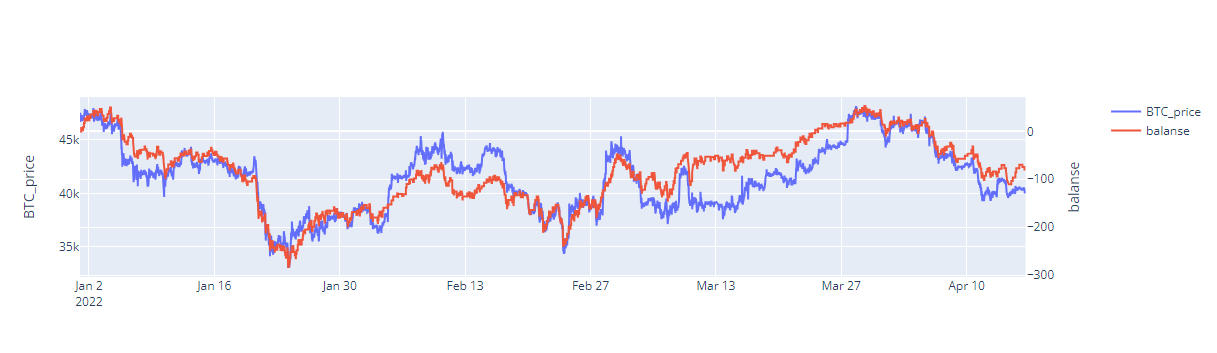

In [ ]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=df_22_RSI['Open time'], y=df_22_RSI['Open'],
                    mode='lines',
                    name='BTC_price'),
                          secondary_y=False) 

fig1.add_trace(go.Scatter(x=df_22_RSI['Open time'], y=df_22_RSI['balanse'],
                    mode='lines',
                    name='balanse'),
                          secondary_y=True)
fig1.update_yaxes(title_text="BTC_price", secondary_y=False)
fig1.update_yaxes(title_text="balanse", secondary_y=True)
fig1.show(width = 20,height=5)

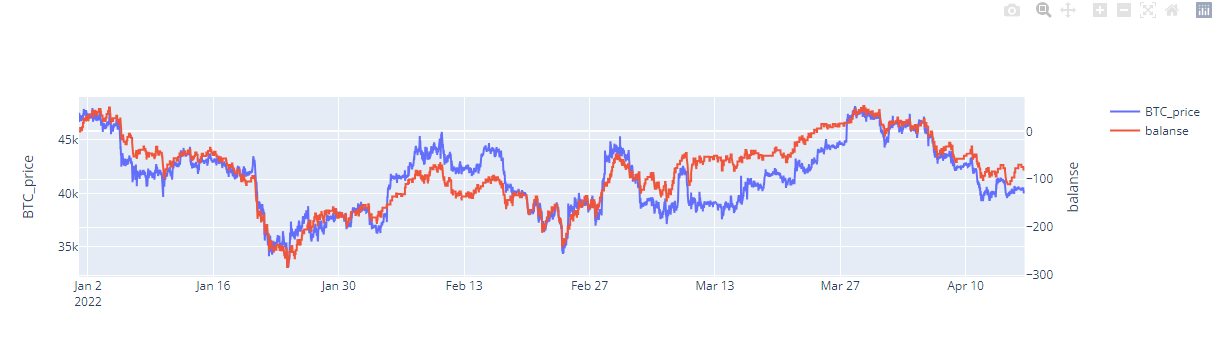

we should try another RSI parameters

RSI_buy = 33 does not work 

We need RIS_buy for each direction, direction will be determined by ADX and DI +,-

In [168]:
df_22_rsi, rsi_B_22, rsi_L_TR_22, rsi_L_P_22 = RSI_strategy_tester(df_22,1000, RSI_buy = 17, RSI_sell = 60, 
                                                                              window = 14, SL = 300, TP = 200, return_df = True)

In [171]:
rsi_B_22.columns = ['Open time', 'balanse', 'long_pos']

In [172]:
df_22_RSI_balance = df_22_rsi.merge(rsi_B_22, how='left', on='Open time').ffill(axis = 0)

In [173]:
df_22_RSI_balance.tail(3)

,Open time,Open,High,Low,Close,RSI,balanse,long_pos
151984,2022-04-16 14:18:00,40136.898438,40140.000000,40122.500000,40125.500000,47.507581,-74.984796,0
151985,2022-04-16 14:19:00,40125.398438,40125.500000,40120.199219,40120.500000,42.735400,-74.984796,0
151986,2022-04-16 14:20:00,40120.601562,40120.601562,40118.000000,40118.101562,40.890301,-74.984796,0


In [ ]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=df_22_RSI_balance['Open time'], y=df_22_RSI_balance['Open'],
                    mode='lines',
                    name='BTC_price'),
                          secondary_y=False) 

fig1.add_trace(go.Scatter(x=df_22_RSI_balance['Open time'], y=df_22_RSI_balance['balanse'],
                    mode='lines',
                    name='balanse'),
                          secondary_y=True)
fig1.update_yaxes(title_text="BTC_price", secondary_y=False)
fig1.update_yaxes(title_text="balanse", secondary_y=True)
fig1.show(width = 20,height=5)

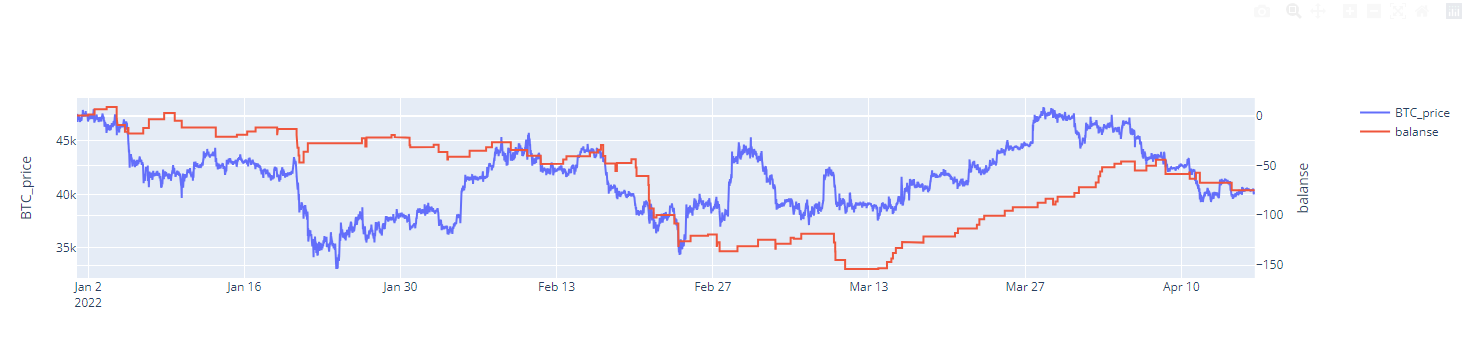

In [175]:
rsi_L_TR_22

,id,ds,buy_price,amount,sell_price,why_closed,result
0,1,2022-01-02 00:32:00,46980.372070,0.021285,47037.921875,RSI,1.224975
1,2,2022-01-02 14:05:00,46903.209961,0.021321,47142.202148,RSI,5.095434
2,3,2022-01-03 16:05:00,45874.443359,0.021799,45980.179688,RSI,2.304907
3,4,2022-01-04 13:36:00,46568.260742,0.021474,46047.835938,Stop,-11.175526
4,5,2022-01-04 13:53:00,45964.705078,0.021756,45645.916992,Stop,-6.935497
...,...,...,...,...,...,...,...
118,119,2022-04-10 17:26:00,43105.349609,0.023199,43170.000000,RSI,1.499823
119,120,2022-04-10 18:18:00,42676.974609,0.023432,42402.875977,Stop,-6.422635
120,121,2022-04-11 07:40:00,40985.250977,0.024399,41231.700195,Take,6.013120
121,122,2022-04-11 16:07:00,39951.899414,0.025030,39553.274414,Stop,-9.977623


In [183]:
df_22_rsi.describe()

,Open,High,Low,Close,RSI
count,151987.000000,151987.000000,151987.000000,151987.000000,151987.000000
mean,41500.285156,41523.578125,41477.050781,41500.234375,49.973997
std,3083.166016,3080.375244,3085.636475,3083.136475,10.947244
min,33040.269531,33132.828125,32853.828125,33038.261719,5.335053
25%,38985.101562,39007.398438,38964.000000,38985.101562,42.632335
50%,41770.300781,41790.000000,41750.000000,41770.109375,50.155180
75%,43549.800781,43571.960938,43526.000000,43549.699219,57.451068
max,48142.898438,48200.000000,48095.000000,48143.000000,97.267054


<AxesSubplot:>

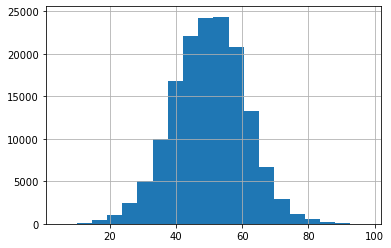

In [193]:
df_22_rsi['RSI'].hist(bins = 20)

In [207]:
rsi_list = []
i_quantile = []
for i in range(17):
    i_quantile.append(i)
    q = i*0.001
    rsi_list.append(df_22_rsi.quantile(q)['RSI'])
    
d = {'quantile/0.001': i_quantile, 'RSI': rsi_list}
pd.DataFrame(data=d)

,quantile/0.001,RSI
0,0,5.335053
1,1,14.754492
2,2,16.814851
3,3,18.255197
4,4,19.356181
5,5,20.314004
6,6,21.125307
7,7,21.767926
8,8,22.378205
9,9,22.875447


In [204]:
rsi_L_TR_22.groupby(['why_closed']).mean()

,buy_price,amount,sell_price,result
why_closed,,,,
RSI,41661.368839,0.024156,41795.940998,3.192361
Stop,40780.290083,0.024655,40426.891047,-8.704625
Take,40986.127441,0.024541,41209.936076,5.518286


In [205]:
rsi_L_TR_22.groupby(['why_closed']).sum()

,buy_price,amount,sell_price,result
why_closed,,,,
RSI,2.291375e+06,1.328563,2.298777e+06,175.579859
Stop,1.794333e+06,1.084819,1.778783e+06,-383.003511
Take,9.836671e+05,0.588984,9.890385e+05,132.438856


In [206]:
rsi_L_TR_22.groupby(['why_closed']).count()

,id,ds,buy_price,amount,sell_price,result
why_closed,,,,,,
RSI,55,55,55,55,55,55
Stop,44,44,44,44,44,44
Take,24,24,24,24,24,24


In [217]:
df_22_rsi, rsi_B_22, rsi_L_TR_22, rsi_L_P_22 = RSI_strategy_tester(df_22,1000, RSI_buy = 15, RSI_sell = 60, 
                                                                              window = 14, SL = 200, TP = 200, return_df = True)

Number of trades decreased by 2

In [219]:
rsi_L_TR_22.groupby(['why_closed']).mean()

,buy_price,amount,sell_price,result
why_closed,,,,
RSI,42174.841910,0.023851,42338.907264,3.891641
Stop,40603.494754,0.024779,40336.064286,-6.645993
Take,41493.674414,0.024260,41713.585026,5.324563


In [220]:
rsi_L_TR_22.groupby(['why_closed']).sum()

,buy_price,amount,sell_price,result
why_closed,,,,
RSI,1.096546e+06,0.620117,1.100812e+06,101.182665
Stop,1.421122e+06,0.867270,1.411762e+06,-232.609761
Take,6.224051e+05,0.363903,6.257038e+05,79.868452


In [221]:
rsi_L_TR_22.groupby(['why_closed']).count()

,id,ds,buy_price,amount,sell_price,result
why_closed,,,,,,
RSI,26,26,26,26,26,26
Stop,35,35,35,35,35,35
Take,15,15,15,15,15,15


I have to create a dict for result of function RSI_strategy_tester

In [242]:
params= {
         'df_init' : df_22,
         'Amount': 1000,
         'column': 'Open',
         'RSI_buy': 14,
         'RSI_sell': 60,
         'window': 14,
         'SL': 200,
         'TP': 300,
         'return_dict': True
         }

In [251]:
%%time
result_14= RSI_strategy_tester(**params)

Wall time: 9min 16s


In [253]:
%%time
params= {
         'df_init' : df_22,
         'Amount': 1000,
         'column': 'Open',
         'RSI_buy': 16,
         'RSI_sell': 60,
         'window': 16,
         'SL': 200,
         'TP': 300,
         'return_dict': True
         }

result_16= RSI_strategy_tester(**params)

Wall time: 9min 5s


### ADX + RSI strategy 

Ok, lets try use ADX and DI+- for trend direction. I want to buy only when DI+ > DI-

In [266]:
def ADX_RSI_strategy_tester(df_init
                 , Amount
                 , RSI_buy: int = 30
                 , RSI_sell: int = 70
                 , RSI_window: int = 14
                 , ADX_window: int = 14
                 , DI_gap: int = 0
                 , SL: int = 200
                 , TP: int = 200
                 , fillna: bool = False
                 , **kwarg):
    '''
    Amount - amount of BTC in USD to buy
    df_init- first output of "to_df" function, this is market history data
    window - window for RSI and ADX
    fillna - fillna attribute of RSI (default fillna = False)
    SL, TP - stop loss and take profit in absolute value of BTC ( ex.: st = 100, tp = 500),  risk = SL * (Amount/BTC PRICE)
    DI_gap - gap between +DI and DI- to buy
   
    return_dict - return result as dict {'df':df,'B':BTC_balance,'LT':long_trades,'LP':long_positions
                                            ,'RSI_buy': RSI_buy,'RSI_sell':RSI_sell,'SL':SL,'TP':TP}
    '''
    new_position_id = 0
    df = df_init.copy()
    df['O_H_L_ave'] = (df['Open'] + df['High'] + df['Low'])/3
    long_positions = pd.DataFrame(columns = ['id', 'ds', 'buy_price', 'amount', 'TP_price', 'SL_price'])
    long_trades = pd.DataFrame(columns = ['id', 'ds', 'sell_price', 'why_closed', 'result'])
    BTC_balance = pd.DataFrame(columns = ['ds', 'balanse', 'long_pos'])
    rsi = ta.momentum.RSIIndicator(df['O_H_L_ave'], RSI_window, fillna)
    adx = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'] , ADX_window, fillna)
    df['-DI'] = adx.adx_neg()
    df['+DI'] = adx.adx_pos()
    df['RSI'] = rsi.rsi()
    
    df.dropna(inplace = True)
    for index, row in df.iterrows():
        ds, Open, High, Low, Close, RSI  = row['Open time'], row['Open'], row['High'],  row['Low'], row['Close'], row['RSI']
        DI_neg, DI_pos =  row['-DI'], row['+DI']
        ave_price = (Open + High + Low + Close)/4
        #buy signal 
        
        if RSI < RSI_buy and (DI_pos - DI_neg > DI_gap) and (len(long_positions) == 0 or len(long_positions) == len(long_trades)):
            new_position_id = new_position_id + 1
            long_positions = long_positions.append({
                'id': new_position_id, 
                'ds': ds,
                'buy_price' : Close,
                'amount' : Amount/Close,  
                'SL_price': Close - SL, 
                'TP_price': Close + TP
                }, ignore_index=True)
        
        #selling 
        if len(long_positions) > len(long_trades):
            #sell by Stop
            if Open < long_positions[-1:]['SL_price'].values[0]:
                long_trades = long_trades.append({
                    'id': new_position_id, 
                    'ds': ds,
                    'sell_price': ave_price,
                    'why_closed' : 'Stop',
                    'result': (ave_price - long_positions[-1:]['buy_price'].values[0])*long_positions[-1:]['amount'].values[0]
                    }, ignore_index=True)
                
             #sell by RSI signal
            elif RSI > RSI_sell:
                long_trades = long_trades.append({
                    'id': new_position_id, 
                    'ds': ds,
                    'sell_price': Close,
                    'why_closed' : 'RSI',
                    'result': (ave_price - long_positions[-1:]['buy_price'].values[0])*long_positions[-1:]['amount'].values[0]
                    }, ignore_index=True)          
            #sell by take
            elif Open > long_positions[-1:]['TP_price'].values[0]:
                long_trades = long_trades.append({
                    'id': new_position_id, 
                    'ds': ds,
                    'sell_price': ave_price,
                    'why_closed' : 'Take',
                    'result': (ave_price - long_positions[-1:]['buy_price'].values[0])*long_positions[-1:]['amount'].values[0]
                    }, ignore_index=True)
                
                
                
        long_pos = len(long_positions) - len(long_trades)
        BTC_balance = BTC_balance.append({'ds': ds,
                                          'balanse': long_trades['result'].sum(),
                                           'long_pos': long_pos
                                         }, ignore_index=True)

    return {'df':df
            ,'B':BTC_balance
            ,'LT':long_trades
            ,'LP':long_positions
            ,'RSI_buy': RSI_buy
            ,'RSI_sell':RSI_sell
            ,'RSI_window':RSI_window
            ,'ADX_window':ADX_window
            ,'SL':SL
            ,'TP':TP
           }

In [261]:
%%time
params= {
         'df_init' : df_22
         ,'Amount': 1000
         , 'RSI_buy':  30
         , 'RSI_sell':  70
         , 'RSI_window':  14
         , 'ADX_window':  14
         , 'DI_gap':  3
         , 'SL': 200
         , 'TP':  200
         , 'fillna':  False
         }

result_RSI_ADX = ADX_RSI_strategy_tester(**params)

Wall time: 5min 50s


In [265]:
result_RSI_ADX['RSI_buy']

30

1 simulation takes 10 min, we will simulate 42 scenarious witj different parameters\
**low RSI + ADX does not work**

In [321]:
def_params= {
         'df_init' : df_22
         ,'Amount': 1000
         , 'RSI_sell':  70
         , 'RSI_window':  14
         , 'SL':  200
         , 'fillna':  False
         }

In [322]:
param_grid = {
          'RSI_buy': [20, 30, 40]
         , 'ADX_window' : [10, 20, 30]
         , 'DI_gap' : [0, 1, 3]
         , 'TP' : [200, 400]
    }

In [332]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
len(all_params)

54

In [337]:
res_balance = []
for params in all_params:
    to_params = {**params, **def_params}
    result = ADX_RSI_strategy_tester(**to_params)
    res_balance.append(result['B']['balanse'].values[-1])
    
cv_results = pd.DataFrame(all_params)
cv_results['result $'] = res_balance
cv_results.to_csv('RSI_ADX_results.csv', index = False)
cv_results

,RSI_buy,ADX_window,DI_gap,TP,result $
0,20,10,0,200,0.000000
1,20,10,0,400,0.000000
2,20,10,1,200,0.000000
3,20,10,1,400,0.000000
4,20,10,3,200,0.000000
5,20,10,3,400,0.000000
6,20,20,0,200,0.000000
7,20,20,0,400,0.000000
8,20,20,1,200,0.000000
9,20,20,1,400,0.000000


In [395]:
cv_results.sort_values('result $', ascending = False).head(3)

,RSI_buy,ADX_window,DI_gap,TP,result $
33,30,30,1,400,26.749666
32,30,30,1,200,25.154595
40,40,10,3,200,17.950941


RSI_buy = 30 is good, i should check 25 and 35\
ADX_window = 30 is good, should try >30\
DI_gap = 1 is good, should try 2\
TP = 400 is good

RSI_sell sould be increased in next iteration !\
TP - carefully increase \
RSI_window = [20, 30]
ADX_window - should be increased to 40, 50, 60 \
RSI_buy = [24 , 35]

Lets have a look at best result

In [343]:
%%time
params= {
         'df_init' : df_22
         ,'Amount': 1000
         , 'RSI_buy':  30
         , 'RSI_sell':  70
         , 'RSI_window':  14
         , 'ADX_window':  30
         , 'DI_gap':  1
         , 'SL': 200
         , 'TP':  400
         , 'fillna':  False
         }

result_RSI_ADX_30_30 = ADX_RSI_strategy_tester(**params)

Wall time: 9min 18s


In [ ]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=result_RSI_ADX_30_30['df']['Open time'], y=result_RSI_ADX_30_30['df']['Open'],
                    mode='lines',
                    name='BTC_price'),
                          secondary_y=False) 

fig1.add_trace(go.Scatter(x=result_RSI_ADX_30_30['B']['ds'], y=result_RSI_ADX_30_30['B']['balanse'],
                    mode='lines',
                    name='balanse'),
                          secondary_y=True)
fig1.update_yaxes(title_text="BTC_price", secondary_y=False)
fig1.update_yaxes(title_text="balanse", secondary_y=True)
fig1.show(width = 20,height=5)

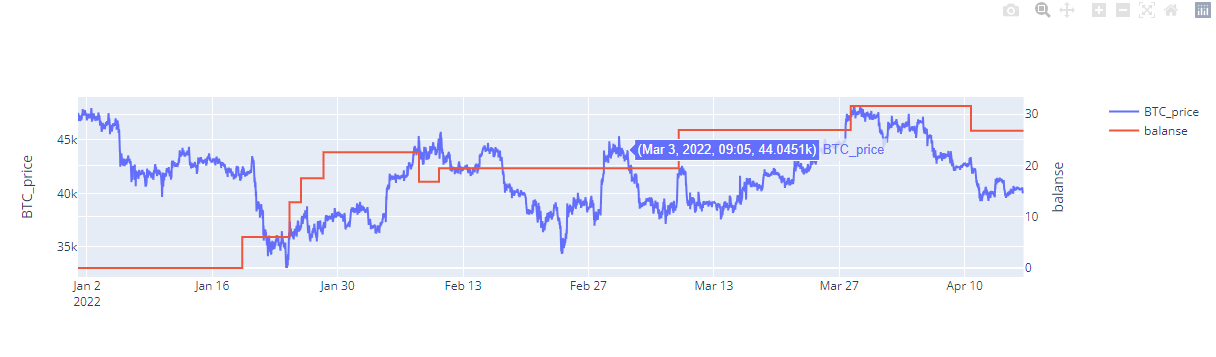

In [348]:
result_RSI_ADX_30_30['LT']

,id,ds,sell_price,why_closed,result
0,1,2022-01-19 08:10:00,42198.000000,RSI,6.063746
1,2,2022-01-24 15:00:00,36139.710938,RSI,6.773329
2,3,2022-01-25 22:08:00,36996.511719,RSI,4.665231
3,4,2022-01-28 10:10:00,37034.378906,RSI,5.073115
4,5,2022-02-08 01:48:00,44542.584961,Stop,-5.745871
5,6,2022-02-10 07:54:00,44848.871094,RSI,2.634802
6,7,2022-03-09 02:26:00,41709.898438,RSI,7.418850
7,8,2022-03-28 07:01:00,47304.199219,RSI,4.692380
8,9,2022-04-10 17:36:00,43026.950195,Stop,-4.825916


In [370]:
ll = result_RSI_ADX_30_30['LP'][['id', 'ds', 'buy_price']]
ll.columns = ['id', 'buy_ds', 'buy_price']

In [372]:
rr = result_RSI_ADX_30_30['LT']
rr.columns = ['id', 'sell_ds', 'sell_price', 'why_closed', 'result']
trade_report = rr.merge(ll,how='left',on='id')

In [375]:
trade_report['duration'] = trade_report['sell_ds'] - trade_report['buy_ds']

In [377]:
trade_report['delta_price'] = trade_report['sell_price'] - trade_report['buy_price']

In [381]:
trade_report = trade_report[['why_closed', 'result', 'duration', 'delta_price']]

In [384]:
trade_report.loc[trade_report['why_closed']=='RSI'].mean()

result                          5.331636
duration       0 days 00:49:17.142857142
delta_price                   226.368304
dtype: object

In [385]:
trade_report.loc[trade_report['why_closed']=='Stop'].mean()

result               -5.285894
duration       0 days 00:31:00
delta_price        -233.033203
dtype: object

In [391]:
trade_report[['why_closed', 'result']].groupby(['why_closed']).count()

,result
why_closed,
RSI,7
Stop,2


Conclusion: only 9 trades. this is too small.\
I need to increase amount of trades.\
Will try RSI_buy = 35

In [396]:
%%time
params= {
         'df_init' : df_22
         ,'Amount': 1000
         , 'RSI_buy':  35
         , 'RSI_sell':  70
         , 'RSI_window':  14
         , 'ADX_window':  30
         , 'DI_gap':  1
         , 'SL': 200
         , 'TP':  400
         , 'fillna':  False
         }

result_RSI_ADX_RTI_35 = ADX_RSI_strategy_tester(**params)

Wall time: 9min 56s


In [ ]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])


fig1.add_trace(go.Scatter(x=result_RSI_ADX_RTI_35['df']['Open time'], y=result_RSI_ADX_RTI_35['df']['Open'],
                    mode='lines',
                    name='BTC_price'),
                          secondary_y=False) 

fig1.add_trace(go.Scatter(x=result_RSI_ADX_RTI_35['B']['ds'], y=result_RSI_ADX_RTI_35['B']['balanse'],
                    mode='lines',
                    name='balanse'),
                          secondary_y=True)
fig1.update_yaxes(title_text="BTC_price", secondary_y=False)
fig1.update_yaxes(title_text="balanse", secondary_y=True)
fig1.show()

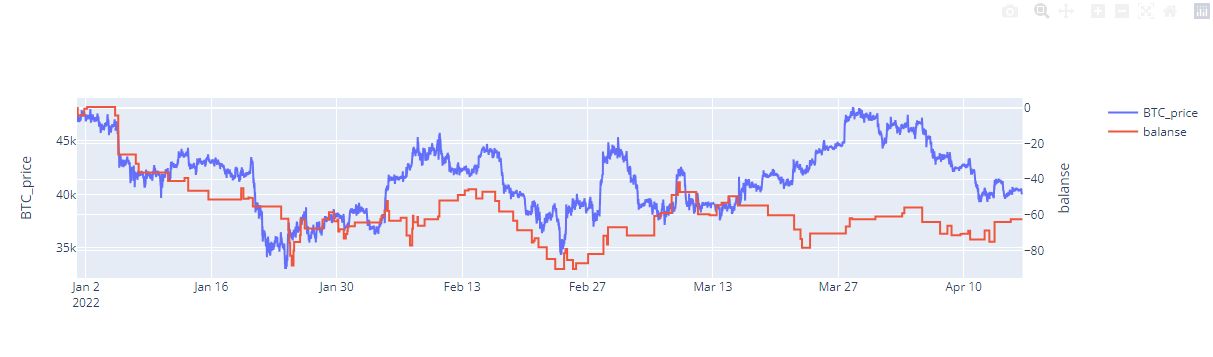

In [402]:
ll = result_RSI_ADX_RTI_35['LP'][['id', 'ds', 'buy_price']]
ll.columns = ['id', 'buy_ds', 'buy_price']

In [403]:
rr = result_RSI_ADX_RTI_35['LT']
rr.columns = ['id', 'sell_ds', 'sell_price', 'why_closed', 'result']
trade_report = rr.merge(ll,how='left',on='id')

In [404]:
trade_report['duration'] = trade_report['sell_ds'] - trade_report['buy_ds']

In [405]:
trade_report['delta_price'] = trade_report['sell_price'] - trade_report['buy_price']

In [406]:
trade_report = trade_report[['why_closed', 'result', 'duration', 'delta_price']]

In [409]:
trade_report[['why_closed', 'result']].groupby(['why_closed']).count()

,result
why_closed,
RSI,63
Stop,51
Take,1


In [527]:
print('Final balance: ',result_RSI_ADX_RTI_35['B']['balanse'][151986])
print('Min balance: ',result_RSI_ADX_RTI_35['B']['balanse'].min())
print('Max balance: ',result_RSI_ADX_RTI_35['B']['balanse'].max())
print(' ')
print('poroportion of stops: ',len(trade_report.loc[trade_report['why_closed']=='Stop'])/len(trade_report))
print('trades per day: ',len(trade_report)/105)
print('average RSI ern: ',trade_report.loc[trade_report['why_closed']=='RSI']['result'].mean(), '$/trade')
print('average lose: ',trade_report.loc[trade_report['why_closed']=='Stop']['result'].mean(), '$/trade')
print('average take: ',trade_report.loc[trade_report['why_closed']=='Take']['result'].mean(), '$/trade')
print('average duration before RSI: ',trade_report.loc[trade_report['why_closed']=='RSI']['duration'].mean())
print('average duration before stop: ',trade_report.loc[trade_report['why_closed']=='Stop']['duration'].mean())
print('average duration before take: ',trade_report.loc[trade_report['why_closed']=='Take']['duration'].mean())

Final balance:  -62.58541723511295
Min balance:  -90.4888654816648
Max balance:  0.5851483614066941
 
poroportion of stops:  0.4434782608695652
trades per day:  1.0952380952380953
average RSI ern:  3.7659973481665583 $/trade
average lose:  -6.053658938937605 $/trade
average take:  8.893355716211634 $/trade
average duration before RSI:  0 days 00:52:16.190476190
average duration before stop:  0 days 00:53:30.588235294
average duration before take:  0 days 00:31:00


In [462]:
result_RSI_ADX_RTI_35['LT'].tail(1)

,id,sell_ds,sell_price,why_closed,result
114,115,2022-04-15 06:27:00,40215.398438,RSI,1.466113


In [463]:
result_RSI_ADX_RTI_35['LP'].tail(1)

,id,ds,buy_price,amount,TP_price,SL_price
114,115,2022-04-15 04:25:00,40157.199219,0.024902,40557.199219,39957.199219


Analysis of last trade shown that before we continue experiment we should understand distribution of RSI when DI+ > DI-

In [467]:
RSI_35_df = result_RSI_ADX_RTI_35['df']

In [ ]:
RSI_35_df.loc[RSI_35_df['+DI'] > RSI_35_df['-DI']]['RSI'].hist(bins = 50)
print('RSI distribution when  DI+ > than DI-, ADX_window=', result_RSI_ADX_RTI_35['ADX_window'])

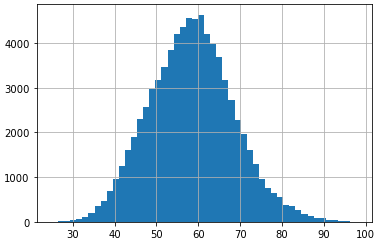

In [513]:
list_price_changin_after_buy_5_min = []
for index, row in result_RSI_ADX_RTI_35['LP'].iterrows():
    date = row['ds']
    aver_prices = RSI_35_df.loc[RSI_35_df['Open time'] > date ].head(5)['O_H_L_ave'].mean()
    buy_price = row['buy_price']
    list_price_changin_after_buy_5_min.append((aver_prices-buy_price))

In [ ]:
plt.hist(list_price_changin_after_buy_5_min, 50)
plt.xlabel('delta price')
plt.title('Histogram of price changin 5 min after buy')
plt.xlim(-50, 50)
plt.grid(True)
plt.show()
print('5 min')
print('Math expectation of price changing: ', np.mean(list_price_changin_after_buy_5_min).round(2), "$")
print('P10 of price changing: ', np.quantile(list_price_changin_after_buy_5_min,q=0.1).round(2), "$")
print('P90 of price changing: ', np.quantile(list_price_changin_after_buy_5_min,q=0.9).round(2), "$")

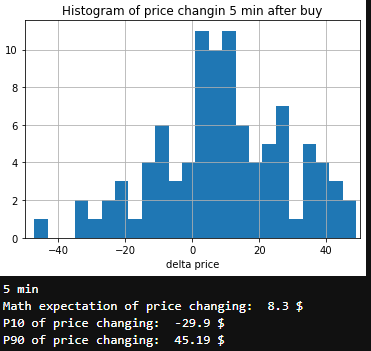

In [ ]:
list_price_changin_after_buy = []
for index, row in result_RSI_ADX_RTI_35['LP'].iterrows():
    date = row['ds']
    aver_prices = RSI_35_df.loc[RSI_35_df['Open time'] > date ].head(10)['O_H_L_ave'].mean()
    buy_price = row['buy_price']
    list_price_changin_after_buy.append((aver_prices-buy_price))
    
plt.hist(list_price_changin_after_buy, 50)
plt.xlabel('delta price')
plt.title('Histogram of price changin 10 min after buy')
plt.xlim(-100, 100)
plt.grid(True)
plt.show()
print('10 min')
print('Math expectation of price changing: ', np.mean(list_price_changin_after_buy).round(2), "$")
print('P10 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.1).round(2), "$")
print('P90 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.9).round(2), "$")

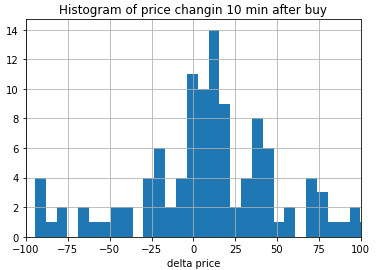

In [552]:
11*96-11*53+90*9

1283

In [ ]:
list_price_changin_after_buy = []
for index, row in result_RSI_ADX_RTI_35['LP'].iterrows():
    date = row['ds']
    aver_prices = RSI_35_df.loc[RSI_35_df['Open time'] > date ].head(15)['O_H_L_ave'].mean()
    buy_price = row['buy_price']
    list_price_changin_after_buy.append((aver_prices-buy_price))
    
plt.hist(list_price_changin_after_buy, 50)
plt.xlabel('delta price')
plt.title('Histogram of price changin 15 min after buy')
plt.xlim(-200, 200)
plt.grid(True)
plt.show()
print('15 min')
print('Math expectation of price changing: ', np.mean(list_price_changin_after_buy).round(2), "$")
print('P10 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.1).round(2), "$")
print('P90 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.9).round(2), "$")

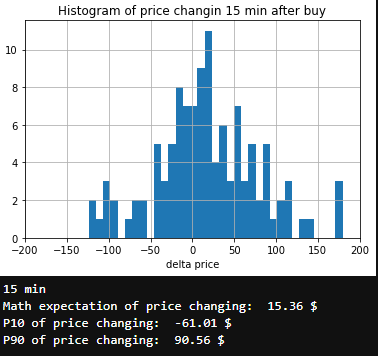

In [553]:
11*90-11*61+90*15

1669

In [ ]:
list_price_changin_after_buy = []
for index, row in result_RSI_ADX_RTI_35['LP'].iterrows():
    date = row['ds']
    aver_prices = RSI_35_df.loc[RSI_35_df['Open time'] > date ].head(20)['O_H_L_ave'].mean()
    buy_price = row['buy_price']
    list_price_changin_after_buy.append((aver_prices-buy_price))
    
plt.hist(list_price_changin_after_buy, 50)
plt.xlabel('delta price')
plt.title('Histogram of price changin 20 min after buy')
plt.xlim(-200, 200)
plt.grid(True)
plt.show()
print('20 min')
print('Math expectation of price changing: ', np.mean(list_price_changin_after_buy).round(2), "$")
print('P10 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.1).round(2), "$")
print('P90 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.9).round(2), "$")

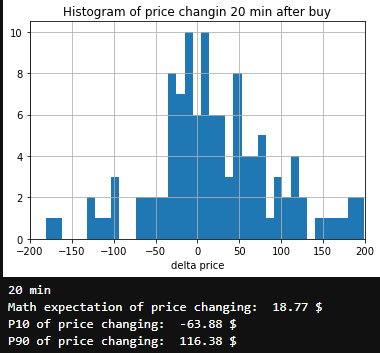

In [ ]:
list_price_changin_after_buy = []
for index, row in result_RSI_ADX_RTI_35['LP'].iterrows():
    date = row['ds']
    aver_prices = RSI_35_df.loc[RSI_35_df['Open time'] > date ].head(20)['O_H_L_ave'].mean()
    buy_price = row['buy_price']
    list_price_changin_after_buy.append((aver_prices-buy_price))
    
plt.hist(list_price_changin_after_buy, 50)
plt.xlabel('delta price')
plt.title('Histogram of price changin 20 min after buy')
plt.xlim(-200, 200)
plt.grid(True)
plt.show()
print('20 min')
print('Math expectation of price changing: ', np.mean(list_price_changin_after_buy).round(2), "$")
print('P10 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.1).round(2), "$")
print('P90 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.9).round(2), "$")

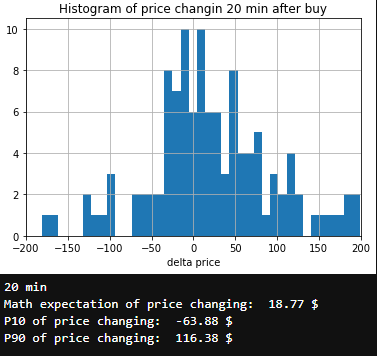

In [554]:
11*116-11*64+90*18

2192

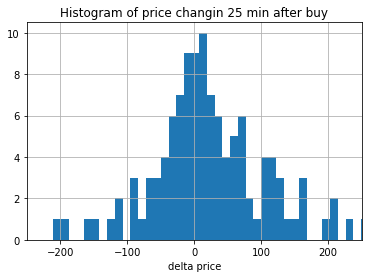

25 min
Math expectation of price changing:  18.79 $
P10 of price changing:  -76.45 $
P90 of price changing:  128.29 $


In [561]:
list_price_changin_after_buy = []
for index, row in result_RSI_ADX_RTI_35['LP'].iterrows():
    date = row['ds']
    aver_prices = RSI_35_df.loc[RSI_35_df['Open time'] > date ].head(25)['O_H_L_ave'].mean()
    buy_price = row['buy_price']
    list_price_changin_after_buy.append((aver_prices-buy_price))
    
plt.hist(list_price_changin_after_buy, 50)
plt.xlabel('delta price')
plt.title('Histogram of price changin 25 min after buy')
plt.xlim(-250, 250)
plt.grid(True)
plt.show()
print('25 min')
print('Math expectation of price changing: ', np.mean(list_price_changin_after_buy).round(2), "$")
print('P10 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.1).round(2), "$")
print('P90 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.9).round(2), "$")

In [555]:
11*129-11*77+90*19

2282

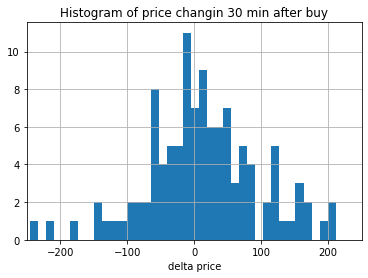

30 min
Math expectation of price changing:  15.91 $
P10 of price changing:  -84.62 $
P90 of price changing:  139.33 $


In [562]:
list_price_changin_after_buy = []
for index, row in result_RSI_ADX_RTI_35['LP'].iterrows():
    date = row['ds']
    aver_prices = RSI_35_df.loc[RSI_35_df['Open time'] > date ].head(30)['O_H_L_ave'].mean()
    buy_price = row['buy_price']
    list_price_changin_after_buy.append((aver_prices-buy_price))
    
plt.hist(list_price_changin_after_buy, 50)
plt.xlabel('delta price')
plt.title('Histogram of price changin 30 min after buy')
plt.xlim(-250, 250)
plt.grid(True)
plt.show()
print('30 min')
print('Math expectation of price changing: ', np.mean(list_price_changin_after_buy).round(2), "$")
print('P10 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.1).round(2), "$")
print('P90 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.9).round(2), "$")

In [556]:
11*139-11*85+90*16

2034

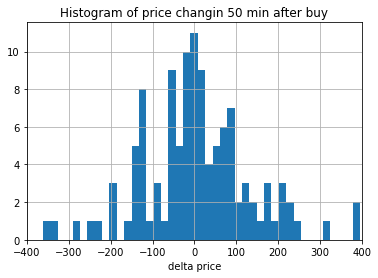

50 min
Math expectation of price changing:  10.93 $
P10 of price changing:  -136.07 $
P90 of price changing:  173.43 $


In [550]:
list_price_changin_after_buy = []
for index, row in result_RSI_ADX_RTI_35['LP'].iterrows():
    date = row['ds']
    aver_prices = RSI_35_df.loc[RSI_35_df['Open time'] > date ].head(50)['O_H_L_ave'].mean()
    buy_price = row['buy_price']
    list_price_changin_after_buy.append((aver_prices-buy_price))
    
plt.hist(list_price_changin_after_buy, 50)
plt.xlabel('delta price')
plt.title('Histogram of price changin 50 min after buy')
plt.grid(True)
plt.xlim(-400, 400)
plt.show()
print('50 min')
print('Math expectation of price changing: ', np.mean(list_price_changin_after_buy).round(2), "$")
print('P10 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.1).round(2), "$")
print('P90 of price changing: ', np.quantile(list_price_changin_after_buy,q=0.9).round(2), "$")

In [557]:
11*173-11*137+90*11

1386

5 min
Math expectation of price changing:  8.3 $
P10 of price changing:  -29.9 $
P90 of price changing:  45.19 $


windgh of histogramm vs distance from buy in min!

### Conclusion

RSI_buy = 30 is good, i should check 25 and 35\
ADX_window = 30 is good, should try >30\
DI_gap = 1 is good, should try 2\
TP = 400 is good

RSI_sell sould be increased in next iteration !\
TP - carefully increase \
RSI_window = [15,20,25,30,35]
ADX_window - should be increased to 40, 50, 60 \
RSI_buy = [24 , 35]

modify strategy_tester with lambda!\
NEXT STEPS: TRY TO FIND STATISTICALLY PROVED POINT OF BUYING.\
FIND ONLY POINT OF BUYING WITHOUT CALCULATION OF SELLING AND RESULT\
modefy RSI and ADX parameter.
Build 2-D probabilyty distribution of price after buy within interval 3-30 minutes

## Probabilitic analysis of 1 min data

### Analysis of price range within 1 minute

In [772]:
min_Price_range = df_22['High']-df_22['Low']

In [ ]:
f = Fitter(min_Price_range,
           xmax=200,
           distributions=['lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

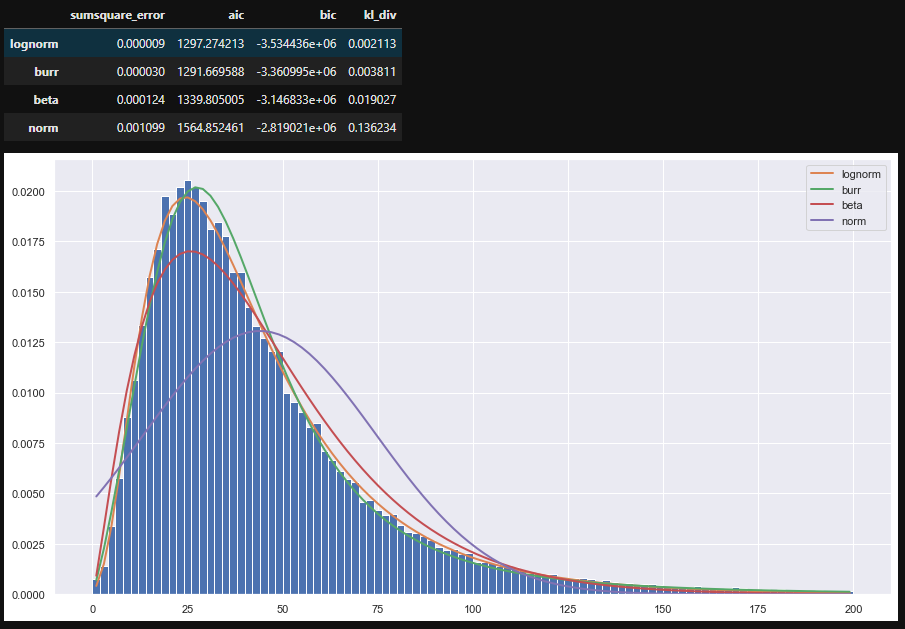

In [779]:
print('Price range LOG_Normal distributed')
print('mean of 1 min range: ', round(min_Price_range.mean(),1), '$')
print('P90 of 1 min range: ', round(min_Price_range.quantile(q=0.1),1), '$')
print('P10 of 1 min range: ', round(min_Price_range.quantile(q=0.9),1), '$')
print('There are LOG_Normal distribution parameters:')
f.get_best(method='sumsquare_error')['lognorm']

Price range LOG_Normal distributed
mean of 1 min range:  46.5 $
P90 of 1 min range:  14.9 $
P10 of 1 min range:  86.4 $
There are LOG_Normal distribution parameters:


{'s': 0.5854983493876542,
 'loc': -4.722306626503319,
 'scale': 41.067186356556874}

Now lets estimate open - cloce distribution

In [822]:
Open_Close_Price_range = df_22['Open']-df_22['Close']

In [ ]:
plt.hist(Open_Close_Price_range, 1000)
plt.xlabel('delta price')
plt.title('Histogram of OPEN_CLOSE within 1 min')
plt.grid(True)
plt.xlim(-100, 100)
plt.show()

In [832]:
f = Fitter(Open_Close_Price_range,
           xmax=200,
           xmin=-200, distributions= ['expon'
                                      ,'exponpow'
                                      ,'gamma'
                                      ,'lognorm'
                                      ,'norm'
                                      ,'uniform']
f.fit()
f.summary()

SyntaxError: invalid syntax (<ipython-input-832-eeffee498a9f>, line 9)

In [779]:
print('Price range LOG_Normal distributed')
print('mean of 1 min range: ', round(Open_Close_Price_range.mean(),1), '$')
print('P90 of 1 min range: ', round(Open_Close_Price_range.quantile(q=0.1),1), '$')
print('P10 of 1 min range: ', round(Open_Close_Price_range.quantile(q=0.9),1), '$')
print('There are LOG_Normal distribution parameters:')
f.get_best(method='sumsquare_error')['lognorm']

Price range LOG_Normal distributed
mean of 1 min range:  46.5 $
P90 of 1 min range:  14.9 $
P10 of 1 min range:  86.4 $
There are LOG_Normal distribution parameters:


{'s': 0.5854983493876542,
 'loc': -4.722306626503319,
 'scale': 41.067186356556874}

### Analysis of price moving witin short time period

Firstly lets investigate price changing in random point

In [781]:
df_rand_points = df_22.copy()

In [782]:
df_rand_points['O_H_L_ave'] = (df_rand_points['Open'] + df_rand_points['High'] + df_rand_points['Low'])/3

In [790]:
zero_list=[ 0 for i in range(len(df_rand_points))]
randomlist = random.sample(range(15, len(df_rand_points)-100), 1000)
for i in randomlist:
    zero_list[i] = 1

In [793]:
df_rand_points['pot_point'] = zero_list

In [817]:
def PAB_dist_calc(df_init, time_gap
                         , max_mim_price:bool = False
                        , Hist_range:int =100
                        ,bins:int=20
                        ):

    df = df_init.copy()
    average_BTC_price = df['O_H_L_ave'].mean()
    lenght = len(df)
    duration = df['Open time'][lenght-1] - df['Open time'][0]

    
    def dist_calc(ds, BTC_price):
        ind = df.index[df['Open time'] == ds].values[0]
        mean_price_list = []
        empty_list = [False for j in range(time_gap)]

        if df.iloc[ind - time_gap : ind]['pot_point'].sum() == 0 and ind > time_gap and ind < lenght-time_gap:
            mean_price_list = [average_BTC_price * (value-BTC_price)/BTC_price for value in df.iloc[ind+1:ind+1+time_gap]['O_H_L_ave'].to_list()]
            return {'M': mean_price_list,'H':  '', 'L': ''}
        else:
            return {'M': empty_list,'H':  '', 'L': ''}
    
    
    def dist_calc_min_max(ds, BTC_price):
        ind = df.index[df['Open time'] == ds].values[0]
        high_price_list = []
        low_price_list = []
        empty_list = [False for j in range(time_gap)]

        if df.iloc[ind - time_gap : ind]['pot_point'].sum() == 0 and ind > time_gap and ind < lenght-time_gap:
            high_price_list = [average_BTC_price * (value-BTC_price)/BTC_price for value in df.iloc[ind+1:ind+1+time_gap]['High'].to_list()]
            low_price_list = [average_BTC_price * (value-BTC_price)/BTC_price for value in df.iloc[ind+1:ind+1+time_gap]['Low'].to_list()]
            return {'M': '','H':  high_price_list, 'L': low_price_list}
        else:
            return {'M': '','H':  empty_list, 'L': empty_list}

    df_m = df.copy()
    # creation and filling price after buying columns
    for i in range(time_gap):
        df_m[str(i)] = df_m.apply(lambda row: dist_calc(row['Open time'], row['Close'])['M'][i] if (row['pot_point'] == 1) else False, axis = 1) 
    
    df_m = df_m.loc[df_m['0'] != False]
    
    buy_num = len(df_m)
    if buy_num!=0:
        buy_freq = duration/buy_num
    else:
        buy_freq =0
    
    hist_m = pd.DataFrame(columns = [str(i) for i in range(time_gap)])
    for i in range(time_gap):
        count, division = np.histogram(df_m[str(i)],range=(-Hist_range,Hist_range), bins=bins) 
        hist_m[str(i)] = count
        hist_m['Price change, $'] = [division[i] + 5 for i in range(len(division)-1)]
    hist_m = hist_m.set_index('Price change, $').sort_values('Price change, $',ascending = False)
    
    if max_mim_price == True:
        df_min = df.copy()
        df_max = df.copy()
        # creation and filling price after buying columns
        for i in range(time_gap):
            df_min[str(i)] = df_min.apply(lambda row: dist_calc_min_max(row['Open time'], row['Close'])['L'][i] if (row['pot_point'] == 1) else False, axis = 1) 
            df_max[str(i)] = df_max.apply(lambda row: dist_calc_min_max(row['Open time'], row['Close'])['H'][i] if (row['pot_point'] == 1) else False, axis = 1) 
            
        df_min = df_min.loc[df_min['0'] != False]
        df_max = df_max.loc[df_max['0'] != False]
        hist_min = pd.DataFrame(columns = [str(i) for i in range(time_gap)])
        hist_max = pd.DataFrame(columns = [str(i) for i in range(time_gap)])
        for i in range(time_gap):
            count, division = np.histogram(df_min[str(i)],(-Hist_range,Hist_range), bins=bins) 
            hist_min[str(i)] = count
            hist_min['Price change, $'] = [division[i] + 5 for i in range(len(division)-1)]
            
            count, division = np.histogram(df_max[str(i)],(-Hist_range,Hist_range), bins=bins) 
            hist_max[str(i)] = count
            hist_max['Price change, $'] = [division[i] + 5 for i in range(len(division)-1)]
        hist_l = hist_min.set_index('Price change, $').sort_values('Price change, $',ascending = False)
        hist_h = hist_max.set_index('Price change, $').sort_values('Price change, $',ascending = False)
        return {'hist_m': hist_m, 'df_m':df_m, 'hist_l': hist_l, 'df_min': df_min, 'hist_h': hist_h, 'df_max': df_max
                , 'Price_mean': average_BTC_price, 'row_num': lenght, 'buy_num': buy_num, 'buy_freq': buy_freq}
    
    return {'hist_m': hist_m, 'df_m':df_m, 'Price_mean': average_BTC_price, 'row_num': lenght, 'buy_num': buy_num, 'buy_freq': buy_freq}

In [819]:
%%time
res = PAB_dist_calc(df_rand_points,5, Hist_range = 200, bins = 20)

Wall time: 9.68 s


In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(res['hist_m'], annot=True)

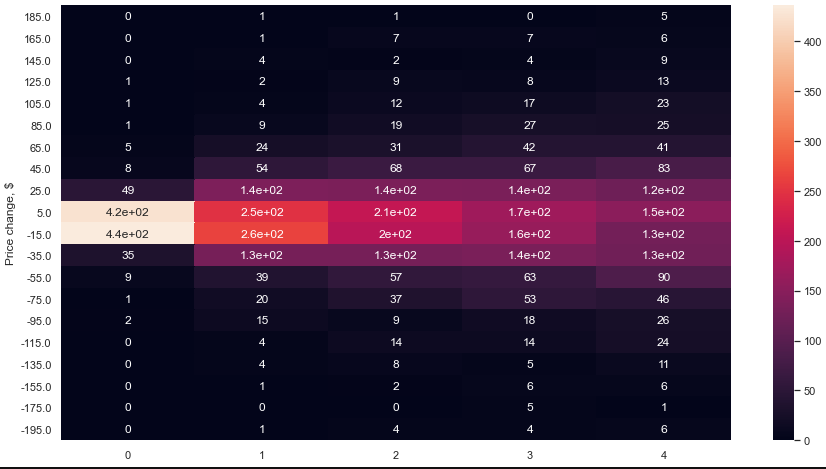

In [ ]:
fig = go.Figure(data=[go.Surface(z=res['hist_m'].values)])
fig.update_layout(title='Price moving in random point', autosize=False,
                  width=1000, height=700)
fig.show()

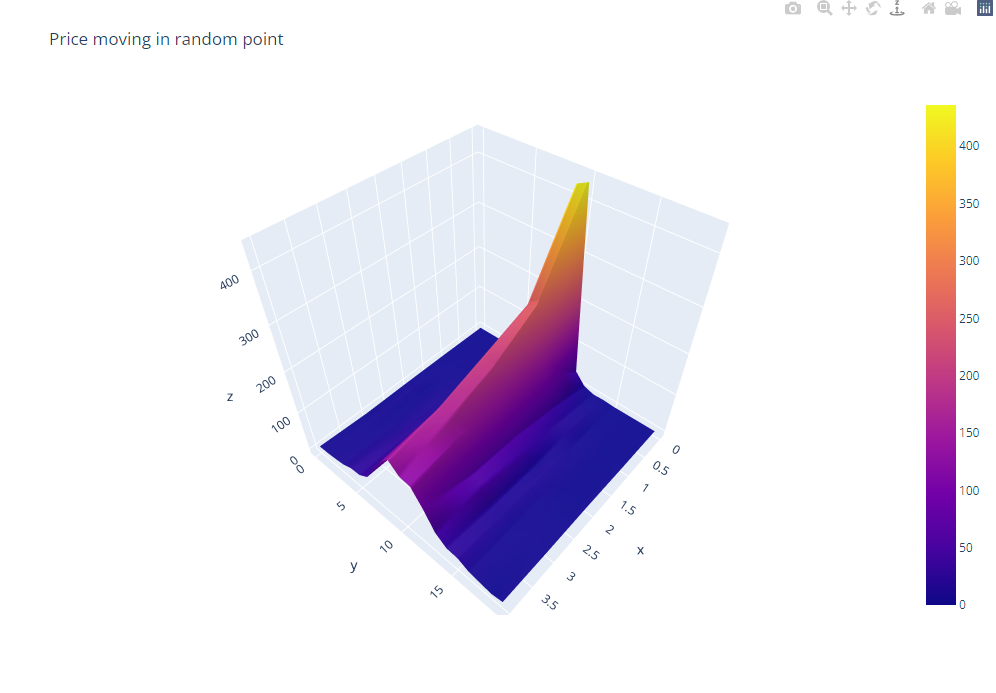

I NEED SEE DISTRIBUTION OF RANDOM POINT

I need estimate duration of trends to choose good ADX parameters.

we need 2 functions for distribution building:

first-indicator calculation\
intake: df, RSI and ADX parameters\
outcome: df_RSI_ADX

second-distribution builder\
intake: df_RSI_ADX\
outcome: hitmap[time after buy, price changing]


In [563]:
def indicator_calculation(df_init
                 , RSI_need: bool = True
                 , ADX_need: bool = False
                 , DI_need: bool = True
                 , RSI_window: int = 14
                 , ADX_window: int = 14
                 , fillna: bool = False
                 , **kwarg):
    '''
    returns df + RSI, DI, ADX columns
    
    '''

    df = df_init.copy()
    df['O_H_L_ave'] = (df['Open'] + df['High'] + df['Low'])/3
    if RSI_need == True:
        rsi = ta.momentum.RSIIndicator(df['O_H_L_ave'], RSI_window, fillna)
        df['RSI'] = rsi.rsi()
    if DI_need == True:
        adx = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'] , ADX_window, fillna)
        df['-DI'] = adx.adx_neg()
        df['+DI'] = adx.adx_pos()
        if ADX_need == True:
            df['ADX'] = adx.adx()
    return df

In [566]:
%%time
df = indicator_calculation(df_22, RSI_window = 14, ADX_window = 40)

Wall time: 1.42 s


In [722]:
def PAB_RSI_DI_dist_calc(df_init
                         , RSI_buy
                         , DI_gap
                         , time_gap
                         , max_mim_price:bool = False
                        ):
    '''
    df - outcome of indicator_calculation function
    '''
    df = df_init.copy()
    average_BTC_price = df['O_H_L_ave'].mean()
    lenght = len(df)
    duration = df['Open time'][lenght-1] - df['Open time'][0]
    def point_search(rsi,di_green, di_red, time_gap):
        if rsi < RSI_buy and di_green-di_red > DI_gap:
            return 1
        else:
            return 0
    df['pot_point'] = df.apply(lambda row : point_search(row['RSI'], row['+DI'], row['-DI'], time_gap) , axis = 1)
    
    def dist_calc(ds, BTC_price):
        ind = df.index[df['Open time'] == ds].values[0]
        mean_price_list = []
        empty_list = [False for j in range(time_gap)]

        if df.iloc[ind - time_gap : ind]['pot_point'].sum() == 0 and ind > time_gap and ind < lenght-time_gap:
            mean_price_list = [average_BTC_price * (value-BTC_price)/BTC_price for value in df.iloc[ind+1:ind+1+time_gap]['O_H_L_ave'].to_list()]
            return {'M': mean_price_list,'H':  '', 'L': ''}
        else:
            return {'M': empty_list,'H':  '', 'L': ''}
    
    
    def dist_calc_min_max(ds, BTC_price):
        ind = df.index[df['Open time'] == ds].values[0]
        high_price_list = []
        low_price_list = []
        empty_list = [False for j in range(time_gap)]

        if df.iloc[ind - time_gap : ind]['pot_point'].sum() == 0 and ind > time_gap and ind < lenght-time_gap:
            high_price_list = [average_BTC_price * (value-BTC_price)/BTC_price for value in df.iloc[ind+1:ind+1+time_gap]['High'].to_list()]
            low_price_list = [average_BTC_price * (value-BTC_price)/BTC_price for value in df.iloc[ind+1:ind+1+time_gap]['Low'].to_list()]
            return {'M': '','H':  high_price_list, 'L': low_price_list}
        else:
            return {'M': '','H':  empty_list, 'L': empty_list}

    df_m = df.copy()
    # creation and filling price after buying columns
    for i in range(time_gap):
        df_m[str(i)] = df_m.apply(lambda row: dist_calc(row['Open time'], row['Close'])['M'][i] if (row['pot_point'] == 1) else False, axis = 1) 
    
    df_m = df_m.loc[df_m['0'] != False]
    
    buy_num = len(df_m)
    if buy_num!=0:
        buy_freq = duration/buy_num
    else:
        buy_freq =0
    
    hist_m = pd.DataFrame(columns = [str(i) for i in range(time_gap)])
    for i in range(time_gap):
        count, division = np.histogram(df_m[str(i)],range=(-100,100), bins=20) 
        hist_m[str(i)] = count
        hist_m['Price change, $'] = [division[i] + 5 for i in range(len(division)-1)]
    hist_m = hist_m.set_index('Price change, $').sort_values('Price change, $',ascending = False)
    
    if max_mim_price == True:
        df_min = df.copy()
        df_max = df.copy()
        # creation and filling price after buying columns
        for i in range(time_gap):
            df_min[str(i)] = df_min.apply(lambda row: dist_calc_min_max(row['Open time'], row['Close'])['L'][i] if (row['pot_point'] == 1) else False, axis = 1) 
            df_max[str(i)] = df_max.apply(lambda row: dist_calc_min_max(row['Open time'], row['Close'])['H'][i] if (row['pot_point'] == 1) else False, axis = 1) 
            
        df_min = df_min.loc[df_min['0'] != False]
        df_max = df_max.loc[df_max['0'] != False]
        hist_min = pd.DataFrame(columns = [str(i) for i in range(time_gap)])
        hist_max = pd.DataFrame(columns = [str(i) for i in range(time_gap)])
        for i in range(time_gap):
            count, division = np.histogram(df_min[str(i)],range=(-100,100), bins=20) 
            hist_min[str(i)] = count
            hist_min['Price change, $'] = [division[i] + 5 for i in range(len(division)-1)]
            
            count, division = np.histogram(df_max[str(i)],range=(-100,100), bins=20) 
            hist_max[str(i)] = count
            hist_max['Price change, $'] = [division[i] + 5 for i in range(len(division)-1)]
        hist_l = hist_min.set_index('Price change, $').sort_values('Price change, $',ascending = False)
        hist_h = hist_max.set_index('Price change, $').sort_values('Price change, $',ascending = False)
        return {'hist_m': hist_m, 'df_m':df_m, 'hist_l': hist_l, 'df_min': df_min, 'hist_h': hist_h, 'df_max': df_max
                , 'Price_mean': average_BTC_price, 'row_num': lenght, 'buy_num': buy_num, 'buy_freq': buy_freq}
    
    return {'hist_m': hist_m, 'df_m':df_m, 'Price_mean': average_BTC_price, 'row_num': lenght, 'buy_num': buy_num, 'buy_freq': buy_freq}

In [723]:
%%time
res = PAB_RSI_DI_dist_calc(df, 30, 1, 5)

Wall time: 8.83 s


In [732]:
%%time
res_1 = PAB_RSI_DI_dist_calc(df, 30, 1, 20, max_mim_price = True)

Wall time: 1min 24s


In [727]:
%%time
res = PAB_RSI_DI_dist_calc(df, 30, 1, 20)

Wall time: 29.4 s


In [736]:
100*20000/40000

50.0

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(res_1['hist_h'], annot=True, square=True, vmax=5)

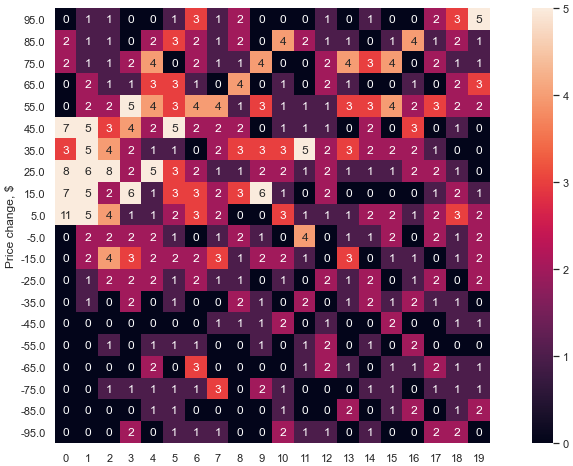

In [683]:
count, division = np.histogram(df_ex['0'],range=(-100,100), bins=20) 

In [684]:
count

array([ 0,  0,  1,  0,  0,  0,  2,  0,  6, 12, 12,  5,  3,  0,  0,  0,  0,
        0,  0,  0], dtype=int64)

In [685]:
division

array([-100.0, -90.0, -80.0, -70.0, -60.0, -50.0, -40.0, -30.0, -20.0,
       -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0,
       100.0], dtype=object)

In [697]:
[division[i] + 5 for i in range(len(division)-1)]

[-95.0,
 -85.0,
 -75.0,
 -65.0,
 -55.0,
 -45.0,
 -35.0,
 -25.0,
 -15.0,
 -5.0,
 5.0,
 15.0,
 25.0,
 35.0,
 45.0,
 55.0,
 65.0,
 75.0,
 85.0,
 95.0]

In [ ]:
datetamo_0101022

In [55]:
datetime.fromtimestamp(datetamo_1604022)

datetime.datetime(2022, 4, 16, 0, 0, 1)

In [47]:
datetime.fromtimestamp(1641013201.0)

datetime.datetime(2022, 1, 1, 0, 0, 1)

In [46]:
datetime.fromtimestamp(1641013210)

datetime.datetime(2022, 1, 1, 0, 0, 10)

In [16]:
dfm, ser = to_df(data_1m)
dfm

,Open time,Open,High,Low,Close
0,2022-04-15 12:51:00,40423.656250,40431.898438,40387.574219,40387.574219
1,2022-04-15 12:52:00,40384.769531,40384.769531,40369.609375,40380.000000
2,2022-04-15 12:53:00,40380.101562,40416.101562,40380.000000,40399.898438
3,2022-04-15 12:54:00,40399.800781,40406.000000,40395.261719,40401.691406
4,2022-04-15 12:55:00,40402.277344,40402.492188,40390.296875,40390.296875
...,...,...,...,...,...
1495,2022-04-16 13:46:00,40125.199219,40125.199219,40112.011719,40112.011719
1496,2022-04-16 13:47:00,40112.238281,40114.601562,40110.699219,40111.101562
1497,2022-04-16 13:48:00,40111.101562,40112.000000,40086.226562,40089.898438
1498,2022-04-16 13:49:00,40090.000000,40110.000000,40087.113281,40109.898438


In [32]:
data[-1][]

[1650041520000,
 '40378.00',
 '40380.10',
 '40360.60',
 '40380.10',
 '153.087',
 1650041579999,
 '6180677.22160',
 1659,
 '56.761',
 '2291660.09970',
 '0']

In [33]:
data = futures_client.klines("BTCUSDT", "1m", **{"limit": 100, 'endTime': 1650041579999})

In [34]:
ddf, ser = to_df(data)
ddf

,Open time,Open,High,Low,Close
0,2022-04-15 11:13:00,40398.398438,40422.800781,40374.898438,40409.500000
1,2022-04-15 11:14:00,40409.601562,40424.500000,40380.398438,40404.500000
2,2022-04-15 11:15:00,40404.500000,40404.601562,40375.000000,40379.800781
3,2022-04-15 11:16:00,40379.800781,40379.898438,40330.101562,40350.000000
4,2022-04-15 11:17:00,40350.000000,40389.800781,40349.800781,40376.398438
...,...,...,...,...,...
95,2022-04-15 12:48:00,40346.101562,40359.000000,40333.800781,40356.699219
96,2022-04-15 12:49:00,40356.800781,40384.601562,40356.800781,40365.898438
97,2022-04-15 12:50:00,40365.800781,40438.000000,40362.300781,40420.898438
98,2022-04-15 12:51:00,40420.800781,40437.898438,40378.000000,40378.101562


In [222]:
def strategy(df, freq, channel, {ma_high, ma_low, SL, TP}):
    '''
    MACD and RSI and ADX - try this thinks instead of just MAs
    
    df- first output of "to_df" function, this is market history data
    channel -  output of "channel_calculation" function, this channel predicted data 
    freq - friquency of rows in df and forecast like '1 min' or D,M
    ma_high, ma_low - windows for rolling(window).mean() function
    SL, TP - stop loss and take profit in absolute value of BTC ( ex.: st = 100, tp = 500)
    '''
    
    balance = 0
    buy_price = 0
    sell_price = 0
    # rename columns of df
    df.columns = ['ds', 'Open','High', 'Low', 'Close']
    
    if channel <> False:
        df = df.merge(channel[['ds', 'yhat_lower', 'yhat_upper']],how='left',on='ds')
    
    
    
    df['rolled_open_high'] = df['Open'].rolling(ma_high, min_periods=5, center=False).mean()
    df['rolled_open_low'] = df['Open'].rolling(ma_low, min_periods=1, center=False).mean()
    
    
    
    df['diff_MAs'] = df['rolled_open_low'] -df['rolled_open_high']
    
    
    
    
    df.dropna(inplace = True)
    for index, row in df.iterrows():
    

    # ####################
        
        if balance == 0 and y_lower_less_than_candle(row) and row['diff_MAs'] > 0 :
            balance = 1
            buy_price = row['Close']
            
        if balance == 1 and y_upper_more_than_candle(row):
            balance = 0
            sell_price = row['Close']
            list_of_trades.append(sell_price-buy_price)
            BTC_balance = BTC_balance.append({'ds': row['ds'] , 'balanse': sum(list_of_trades)}, ignore_index=True)
           
    return df.merge(BTC_balance,how='left',on='ds').ffill(axis = 0)

In [224]:
BTC_balance=SL_TP_MA_chanel_strategy(dfm, result_df, '1 min', 20, 6, 100, 100)
BTC_balance.tail(3)

,ds,Open,High,Low,Close,trend,yhat_lower,yhat_upper,rolled_open_high,rolled_open_low,diff_MAs,balanse
1097,2022-04-14 21:52:00,39935.898438,39953.199219,39935.898438,39952.898438,38664.110233,39880.437925,39939.916290,39904.015430,39925.019531,21.004102,-794.582031
1098,2022-04-14 21:53:00,39952.898438,39957.000000,39949.851562,39949.960938,40266.683722,39890.848086,39947.787039,39906.679102,39928.186198,21.507096,-794.582031
1099,2022-04-14 21:54:00,39949.960938,39951.621094,39949.957031,39951.500000,41806.667115,39896.843656,39958.901348,39909.396680,39933.743490,24.346810,-794.582031


## Tunining of channel parameters

Stan is library for probabilistic calculation, should try it

SO, new data complitely new result, try to do crooss validation lag for forecast

In [212]:
result_df_300_300 = result_df
result_df_300_200= channel_calculation(ser_m, 300, 200, 1,'1 min')
result_df_400_400= channel_calculation(ser_m, 400, 400, 1,'1 min')

In [214]:
result_df_300_200.tail(3)

,ds,y,trend,yhat_lower,yhat_upper
1397,2022-04-14 21:52:00,39935.898438,42090.647763,39899.313246,39947.793209
1398,2022-04-14 21:53:00,39952.898438,43420.095899,39901.426492,39951.915640
1399,2022-04-14 21:54:00,39949.960938,44146.171001,39910.076671,39963.209998


In [215]:
BTC_balance=MA_chanel_strategy(dfm, result_df_300_200, '1 min', 20, 6)
BTC_balance.tail(3)

,ds,Open,High,Low,Close,trend,yhat_lower,yhat_upper,rolled_open_high,rolled_open_low,diff_MAs,balanse
1097,2022-04-14 21:52:00,39935.898438,39953.199219,39935.898438,39952.898438,42090.647763,39899.313246,39947.793209,39904.015430,39925.019531,21.004102,-827.730469
1098,2022-04-14 21:53:00,39952.898438,39957.000000,39949.851562,39949.960938,43420.095899,39901.426492,39951.915640,39906.679102,39928.186198,21.507096,-827.730469
1099,2022-04-14 21:54:00,39949.960938,39951.621094,39949.957031,39951.500000,44146.171001,39910.076671,39963.209998,39909.396680,39933.743490,24.346810,-827.730469


# OTHERS

<AxesSubplot:xlabel='ds'>

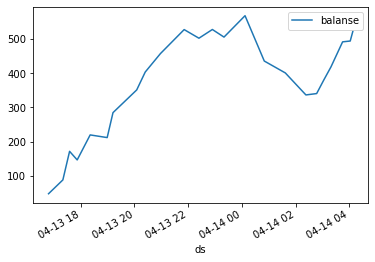

In [69]:
list_of_trades.plot(x = 'ds', y= 'balanse')

In [32]:
result_df[['ds', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat_lower,yhat_upper
997,2022-04-14 04:09:00,41199.729690,41247.273305
998,2022-04-14 04:10:00,41208.136045,41255.761289
999,2022-04-14 04:11:00,41215.057233,41261.803832


In [77]:
dfm.tail(3)

,ds,Open,High,Low,Close
997,2022-04-14 04:09:00,41261.699219,41287.199219,41250.566406,41254.554688
998,2022-04-14 04:10:00,41259.500000,41285.000000,41256.000000,41279.285156
999,2022-04-14 04:11:00,41281.199219,41285.000000,41278.101562,41284.300781


In [101]:
m = Prophet()
m.fit(ser_m)
future = m.make_future_dataframe(periods=1, freq='1 min', include_history = True)
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
